# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Models

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.
mpl.rcParams['patch.force_edgecolor'] = True

## 1.2 Read Data

In [2]:
# file_path= './data/NCDC/uk/marham/dat.txt' 
file_path= './data/NCDC/uk/tiree/dat.txt'  # try 4
# file_path= './data/NCDC/uk/boscombe_down/dat.txt' # 4?, numpy bug
# file_path= './data/NCDC/uk/middle_wallop/dat.txt' 
# file_path= './data/NCDC/uk/southhamption/dat.txt' # high 0, trend
# file_path= './data/NCDC/uk/bournemouth/dat.txt' # 4?
# file_path= "./data/NCDC/uk/weybourne/dat.txt"
# file_path= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# file_path= "./data/NCDC/uk/wattisham/dat.txt"
# file_path= "./data/NCDC/uk/south_uist_range/dat.txt" # inpropoer direction R square measure
# file_path= "./data/NCDC/uk/holbeach/dat.txt" # inpropoer direction R square measure
# file_path= "./data/NCDC/uk/cambridge/dat.txt" # inpropoer direction R square measure
# file_path= "./data/NCDC/us/baltimore/dat.txt" # time too short
# file_path= "./data/NCDC/uk/bealach_na_ba/dat.txt" # time too short
# file_path= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# file_path= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?, trend, no 0
# file_path= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# file_path= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # recent year corrupted
# file_path= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good; numpy problem
# file_path= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good; numpy problem

# file_path= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# file_path= "./data/NCDC/europe/neuburg/dat.txt"
# file_path= "./data/NCDC/europe/valladolid/dat.txt"
# file_path= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good, trend
# file_path= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# file_path= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# file_path= "./data/NCDC/europe/holzdorf/dat.txt" # 2008 year
# file_path= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# file_path= "./data/NCDC/europe/barayas/dat.txt" # numpy problem
# file_path= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s), mixed report type
# file_path= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# file_path= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Good data, Weird KDE shape, might be blocked?
# file_path= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0, few data 
# file_path= "./data/NCDC/oceania/narrandera/dat.txt" # high 0, few data
# file_path= "./data/NCDC/oceania/canberra/dat.txt" # high 0, numpy problem

# file_path= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# file_path= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# file_path= "./data/NCDC/cn/nanjing_lukou/dat.txt" 
# file_path= "./data/NCDC/cn/zhengzhou_xinzheng/dat.txt" 
# file_path= "./data/NCDC/cn/tianjin/binhai/dat.txt" # few 0, trend, stationary speed, unstationary direction
# file_path= "./data/NCDC/cn/tianjin/tianjing/dat.txt" # 16 sectors
# file_path= "./data/NCDC/cn/hefei_luogang/dat.txt" # few 0, trend
# file_path= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# file_path= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# file_path= "./data/NCDC/cn/nanning_wuxu/dat.txt" # numpy priblem, unstationary speed
# file_path= './data/NCDC/cn/macau/dat.txt'  
# file_path= "./data/NCDC/cn/hk_intl/dat.txt" # few 0

# file_path= "./data/cn_database/广州.txt" 
# file_path= "./data/cn_database/北京.txt" 

# file_path = 'TOP/hr_avg.csv' # High 0
# file_path = './data/asos/denver/hr_avg.csv'

# file_path = './data/asos/bismarck_ND/hr_avg.csv' # try 4?
# file_path = './data/asos/aberdeen_SD/hr_avg.csv' # only to 2012, good fit, try 2
# file_path = './data/asos/minneapolis/hr_avg.csv'

# file_path = './data/asos/lincoln_NE/hr_avg.csv' 
# file_path = './data/asos/des_moines_IA/hr_avg.csv'
# file_path = './data/asos/springfield_IL/hr_avg.csv' # good fit

In [3]:
if "cn_database" in file_path: 
    df = read_cn_database(file_path)
elif 'NCDC' in file_path:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
    df.dropna(subset=['dir','speed'], inplace=True)
    integer_data = True
else:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df['type']='default'
    df['wind_type']='default'
    df = df.dropna()
    integer_data = False
    knot_unit = True

In [4]:
df['time']=pd.to_datetime(df["date"].astype(str).map(str) + df["HrMn"], format='%Y%m%d%H%M')
df.set_index(['time'], inplace=True)
df['HrMn']=df['HrMn'].astype(int)
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20170000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


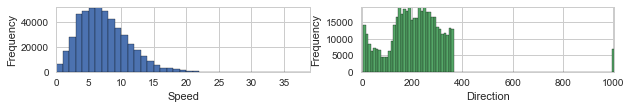

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date           HrMn            dir          speed  \
count  4.853830e+05  485383.000000  485383.000000  485383.000000   
mean   2.000788e+07    1153.725957     205.073847       7.268022   
std    1.142918e+05     670.111036     129.567515       3.840033   
min    1.979010e+07       0.000000       0.000000       0.000000   
25%    1.991013e+07     600.000000     130.000000       4.600000   
50%    2.003032e+07    1120.000000     200.000000       6.700000   
75%    2.011102e+07    1700.000000     270.000000       9.800000   
max    2.016080e+07    2350.000000     999.000000      38.600000   

               month   dir_windrose  
count  485383.000000  485383.000000  
mean        6.484026     204.830806  
std         3.442359     134.306571  
min         1.000000       0.000000  
25%         4.000000     140.000000  
50%         6.000000     200.000000  
75%         9.000000     270.000000  
max        12.000000     999.000000

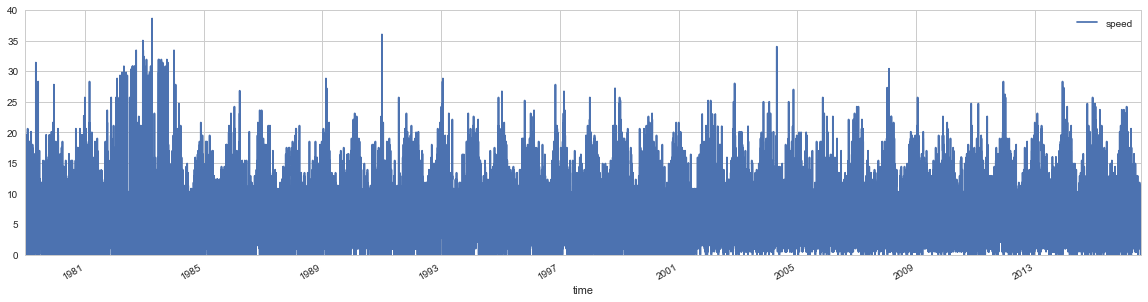

In [7]:
df.plot(y='speed',legend=True,figsize=(20,5))

### 1.2.1 Unit Detection

True


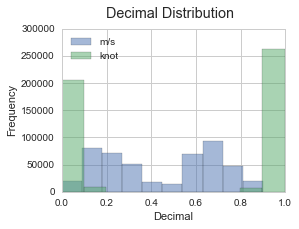

In [8]:
speed_unit_text = ' (knot)'
dir_unit_text = ' (degree)'
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
        speed_unit_text = ' (knot)'
    else:
        speed_unit_text = ' (m/s)'
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')
    df.drop(['decimal'], 1,inplace=True)
print(knot_unit)

### 1.2.2 Sampling Type Selection

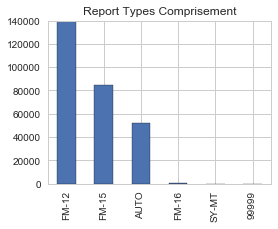

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

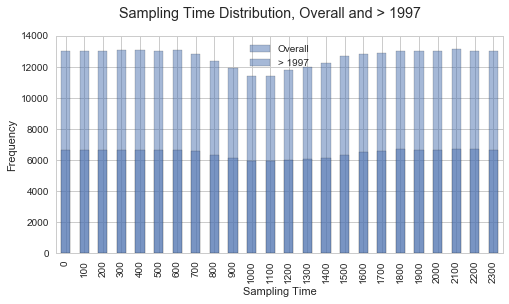

In [10]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2

df['HrMn'].value_counts().sort_index().plot(kind='bar', alpha=0.5,label='Overall')
df.query('date > @MID_YEAR * 10000')['HrMn'].value_counts().sort_index().plot(
    kind='bar', alpha=0.5, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 4), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

[0]


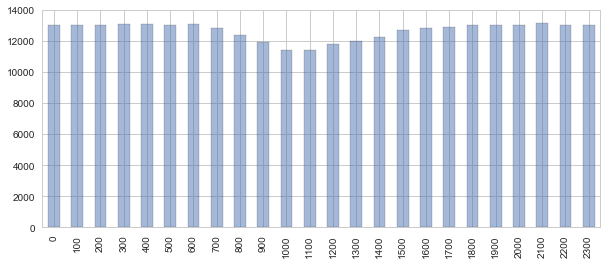

In [11]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)
print(sample_times)

df['HrMn'].value_counts().sort_index().plot(kind='bar', alpha=0.5, figsize=(10, 4))

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [12]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

Empty DataFrame
Columns: [date, HrMn, type, dir, speed, wind_type, month, dir_windrose]
Index: []

#### 1.3.1.2 sudden increase in speed

date  HrMn   type  dir  speed wind_type  month  \
time                                                                      
1991-01-03 06:00:00  19910103   600  FM-12  200     70         N      1   
2004-04-21 11:00:00  20040421  1100  FM-12  290     66         N      4   
1983-10-18 14:00:00  19831018  1400  FM-12  210     61         N     10   
1979-05-09 01:00:00  19790509   100  FM-12  140     61         N      5   
1989-02-13 15:00:00  19890213  1500  FM-12  160     56         N      2   
1993-01-21 21:00:00  19930121  2100  FM-12  180     56         N      1   
1993-01-17 05:00:00  19930117   500  FM-12  180     55         N      1   
2011-12-08 14:00:00  20111208  1400  FM-12  180     55         N     12   
1981-02-27 04:00:00  19810227   400  FM-12  320     55         N      2   
1979-06-06 04:00:00  19790606   400  FM-12  250     55         N      6   

                     dir_windrose  incre  incre_reverse  
time                                                     
1991-01-03 06:00:00           250   44.0           46.0  
2004-04-21 11:00:00           160   33.0           32.0  
1983-10-18 14:00:00           240   31.0           24.0  
1979-05-09 01:00:00           310   45.0           48.0  
1989-02-13 15:00:00           290    6.0            6.0  
1993-01-21 21:00:00           270    8.0            6.0  
1993-01-17 05:00:00           270   12.0            3.0  
2011-12-08 14:00:00           270    3.0            6.0  
1981-02-27 04:00:00           130   19.0           22.0  
1979-06-06 04:00:00           200   49.0           48.0

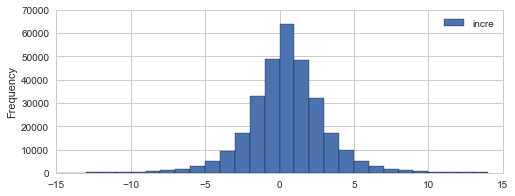

In [13]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [14]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
display(df.sort_values(by='speed',ascending=False).head(10))
df.drop(['incre', 'incre_reverse'], 1, inplace=True)

sudden increase number 22


date  HrMn   type  dir  speed wind_type  month  \
time                                                                      
1993-01-21 21:00:00  19930121  2100  FM-12  180     56         N      1   
1989-02-13 15:00:00  19890213  1500  FM-12  160     56         N      2   
1993-01-17 05:00:00  19930117   500  FM-12  180     55         N      1   
1981-02-27 04:00:00  19810227   400  FM-12  320     55         N      2   
2011-12-08 14:00:00  20111208  1400  FM-12  180     55         N     12   
1979-12-17 01:00:00  19791217   100  FM-12  210     54         N     12   
1984-01-21 19:00:00  19840121  1900  FM-12  310     54         N      1   
2011-12-08 12:00:00  20111208  1200  FM-12  190     54         N     12   
2008-01-09 05:00:00  20080109   500  FM-12  170     53         N      1   
1996-11-06 05:00:00  19961106   500  FM-12  210     53         N     11   

                     dir_windrose  incre  incre_reverse  
time                                                     
1993-01-21 21:00:00           270    8.0            6.0  
1989-02-13 15:00:00           290    6.0            6.0  
1993-01-17 05:00:00           270   12.0            3.0  
1981-02-27 04:00:00           130   19.0           22.0  
2011-12-08 14:00:00           270    3.0            6.0  
1979-12-17 01:00:00           240    1.0            2.0  
1984-01-21 19:00:00           140    4.0            2.0  
2011-12-08 12:00:00           260    2.0            2.0  
2008-01-09 05:00:00           280   13.0           15.0  
1996-11-06 05:00:00           240   34.0            5.0

### 1.3.2 0 Speed

In [15]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.00653928680903


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [16]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
if integer_data:
    SECTOR_LENGTH = 360/len(effective_column) 
else: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0       2920
10      2831
20      4235
30      4516
40      4623
50      4010
60      5202
70      6821
80      8805
90      8527
100     8698
110     7263
120     7665
130     7077
140     8106
150     8517
160    10467
170    10216
180    11171
190    11178
200    12361
210    11430
220    12151
230    10247
240    10279
250     9925
260    12179
270    11267
280    12124
290    11058
300    12298
310    10270
320     8852
330     5863
340     4178
350     2837
999     4034
Name: dir, dtype: int64

36 10.0


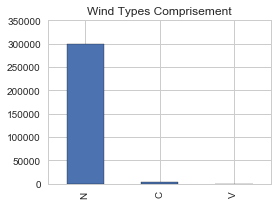

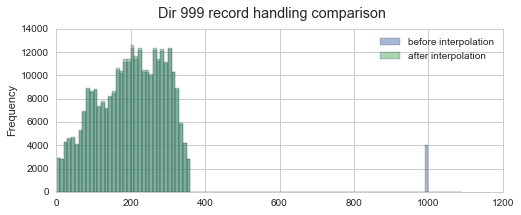

In [17]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

## 1.4 Time Shift Comparison

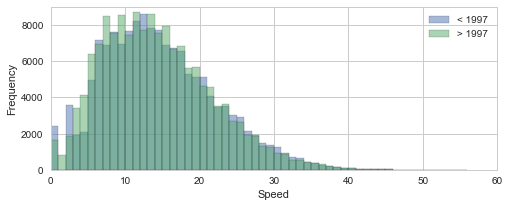

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, df.speed.max() + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

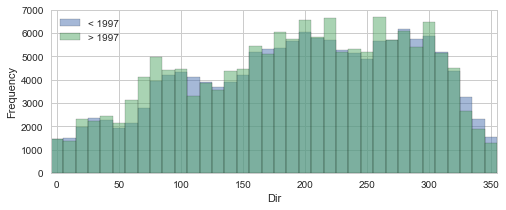

In [19]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), tight='x')

1979 - 1979


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


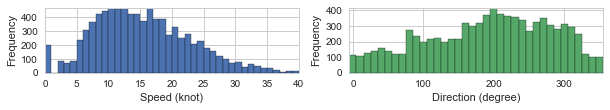

1980 - 1984


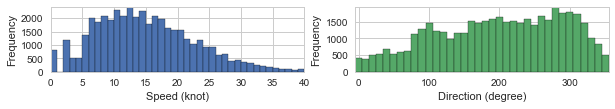

1985 - 1989


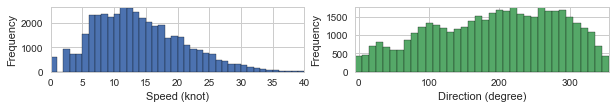

1990 - 1994


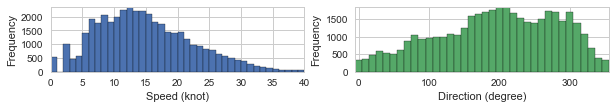

1995 - 1999


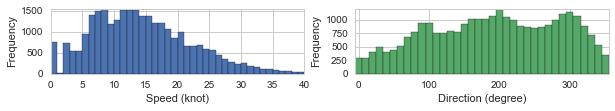

2000 - 2004


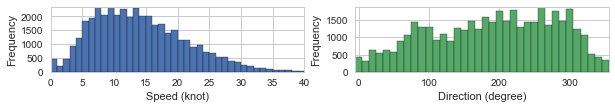

2005 - 2009


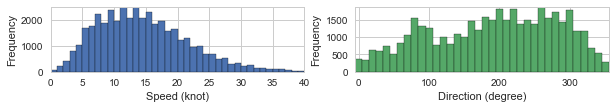

2010 - 2014


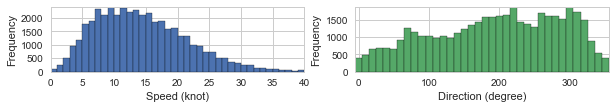

2015 - 2016


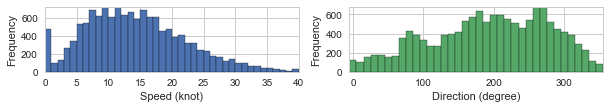

In [20]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df, speed_unit_text=speed_unit_text, dir_unit_text=dir_unit_text)

(0, 25.0)

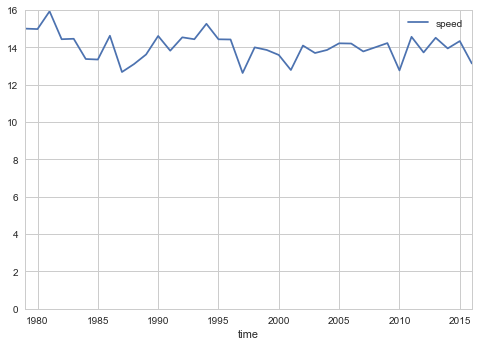

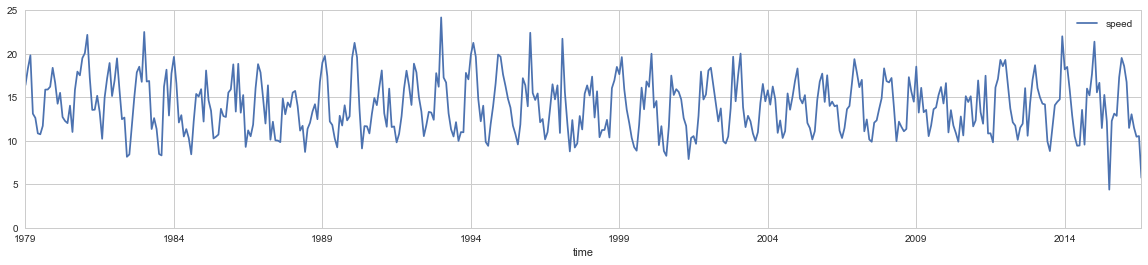

In [21]:
df.resample('A').mean().plot(y='speed')
plt.gca().set_ylim(bottom=0)
df.resample('M').mean().plot(y='speed', figsize=(20,4))
plt.gca().set_ylim(bottom=0)

In [22]:
display(df[df['dir'].isnull()])
df.dropna(subset=['dir'], inplace=True)

Empty DataFrame
Columns: [date, HrMn, type, dir, speed, wind_type, month, dir_windrose]
Index: []

In [23]:
for column in ['speed', 'dir']:
    if column == 'speed':
        bins = arange(0, df[column].max()+1, 1)
    else:
        bins = arange(0, 361, 10)
    den, _ = np.histogram(df[column], bins=bins, density=True)
    y_top=max(den)*1.2
    for year in arange(1980, 2016):
        end_year = year
        sub_df = df[str(year):str(end_year)]
        if len(sub_df) > 5000:
            plt.figure()
            df[column].hist(bins=bins, alpha=0.3, normed=True)
            sub_df[column].hist(bins=bins, alpha=0.5, figsize=(3,1.5), normed=True)
            plt.gca().set_ylim(top=y_top)
            plt_configure(title=str(year))
    align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAANYAAAB6CAYAAADDPa27AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAFCBJREFUeJztnXtwVPXZxz97yd6z2dwIigkaFFGp5SaBGcEWxsqUF9sB
pgSd+EftO1MHa61KcSyNiJkS6G1aRym2MsMEcaySdqBV36mFFlCMBklrgBaLlZB7stfsJdnLOe8f
cU82CtkkZLO7J7/PX2fPZfN7dvI9l+c8z/enkWVZRiAQTCjadA9AIFAjQlgCQQoQwhIIUoAQlkCQ
AoSwBIIUIIQlEKQAIawMRZZlvvOd77B//35lncfj4YknnqCiooI777yTX//610iSpGz3+/089dRT
LFmyhCVLlrBlyxbcbreyPRKJsH37dioqKqioqGDXrl3EYrFJjWuqIISVgcRiMbZt28bx48eHrf/e
977Hv/71L3bv3s3zzz/PX/7yF372s58p25955hk+/vhj9u7dy0svvcTHH3/M1q1ble2/+MUvOHHi
BHv27OGXv/wlhw4dYs+ePZMW15RCFmQULS0tcmVlpfzVr35VXrRokVxXVyfLsiw3NzfLs2fPls+c
OaPse/r0afm2226TA4GALMuyvGDBAvnw4cPK9kOHDsnz5s2TZVmW+/v75S9/+cvy22+/rWyvr6+X
ly5dKsdisckIbUohrlgZxunTpykvL6e+vp7c3FxlfUtLCyaTiVtvvVVZN2fOHCKRCM3NzQDk5+dz
+PBh+vr68Pv9/OlPf2Lu3LkAnDt3jlAoxOLFi5XjFy1ahNPppKWlZZKimzro0z0AwXDuvfde7r33
3i+sLy4upr+/H5fLRUFBAQBtbW0AuFwuAJ599lk2b97MHXfcAUBpaSkHDhwAoKurC7PZPEysxcXF
AHR2dnL99denLKapiLhiZQm33347M2fO5Omnn8br9eJ2u6mtrUWv1xOJRAD45JNPuOGGG9i3bx/7
9u0jNzeXzZs3I8syoVAIo9E47DsNBgMA4XB40uNRO+KKlSUYDAaee+45HnvsMSoqKjCbzTz88MOc
OXMGm81GS0sLNTU1vPXWW8ycOROA5557jpUrV/L+++9jMpm+IKD4Z7PZPOnxqB0hrCzi5ptv5s9/
/jNOpxObzUYsFmPXrl2UlpbS3NyMyWRSRAUwY8YM8vPzuXTpEjfeeCPBYBC/34/NZgOgp6cHgJKS
krTEo2bErWCW4PV6ue+++2hra6OwsBCj0cjRo0cpLi5m1qxZlJSUEAwGaW1tVY7p7e3F4/FQVlbG
nDlzMJvNnDp1Stne2NhIUVERZWVl6QhJ1QhhZQl5eXkMDAywY8cOPv30U44fP8727dt5+OGH0Wg0
zJs3j7lz57J582aam5s5e/Ysjz32GHPnzmXRokWYTCbWr1/P9u3bOXXqFCdPnuTnP/85DzzwQLpD
UyUaWc6MRsfEM6lgkEceeYTVq1dzzz33ANDd3c1LL73E+fPnsdvtrF69mq997WvK/l6vl/379/PR
Rx8B8KUvfYmqqirsdjsw+Ey1b98+3nvvPXJycli+fDmVlZVoteL8moyFCxeOaf+MEtZYB59NqDk+
NccG44tPnKoEghQghCUQpAAhLIEgBQhhCQQpIKmwJEmiurqaDRs2UFVVxcWLF4dtP3LkCOvWrWPD
hg38/ve/V9bv2bOHDRs2sHbtWl577bWJH7lAkMEkrbx4++23CYfDvPrqqzQ1NVFbW8vu3buBwca5
HTt28Prrr2M2m9m4cSMrVqzgwoULnD59mldeeYVQKMTevXtTHohAkEkkFdapU6dYtmwZAPPmzVNa
FAAuXLhAWVkZeXl5wGCu/4MPPuDs2bPMnj2bTZs24ff7+eEPfziqwaTjXZYkSfh8PgDsdntK3+mo
+V2dmmMbD0mFlVhbBqDT6YhGo+j1evx+/7A2BKvVit/vx+12097ezm9+8xtaW1t56KGHeOutt9Bo
NCP+rXS8C3E6nbzccBBJklhdtlJpycjPz59Qkan5XY+aY4PxnTSSCstmsxEIBJTPkiSh1+svuy0Q
CJCbm4vD4aC8vByDwUB5eTlGoxGXy0VhYeGYBzgZWO02/N4+/vDPNyksKSLg83N/xbqMHa8g80l6
Sl6wYAHHjh0DoKmpidmzZyvbZs2axcWLF/F4PITDYRobG5k/fz4LFy7k+PHjyLJMV1cXoVAIh8OR
uijGiCRJOJ1OnE4nLpeLePGJ1W4l12HHarcl+QaBYGSSXrHuvvtu3nnnHSorK5FlmZ/85CccPnyY
YDDIhg0bePLJJ3nwwQeRZZl169ZRUlJCSUkJH3zwAevXr0eWZaqrq9HpdJMRz6hwu9283HAQq91G
d2sn9sK8dA9JoDKSCkur1bJ9+/Zh62bNmqUsr1ixghUrVnzhuNEmLNKF1W4j12HH7/ERjkSIhWPo
DIM/hyRJSrt73F4s/rw10c9eAnUy5RsdI5EY3b4AsYEY1xkHr6rBvgB/6Bl83upu7USXoxfPXoIx
MeWFBaDT6pH1EIlEiYTDhMNRckw5mCwmcoxGTDYTuQ57uocpyCKEsD4jFo3R6exDYwrQ1uFEa8oh
qrfR2eNTrmQCwWiZMsKSJEmxW07MBCai1+nR5+Sg1ecoyzq9EJVg7EwZYV0+EyiygYLUoDphybJM
MBhUPlssFjQaDbIsYzAZleem0bZNyww9e0XCkcte6QSCz6M6YQWDQU58+F9MJguhUIAFc0qwWq30
9vbS2uUlL6Klo8fLdK1MJBwmGouM+H2Jz14+l3eYaAWCK6E6YQGYTBbMFguhUJD3/nmJvLx8Wi5e
QqPRoM/JATSKWDq7fRisIxtWDj176QkGgwQCAeVKKBBcDtW/6TSazJgtFozG4eJJTFSMllg0SuPZ
Nk58+F9x5RKMiOqFNdEYjWZMJku6hyHIcFRzKxhPWgQCAZFgEKQd1QgrnrToDwUxWWxYrNZ0D0kw
hVGNsGAwaTEZF6t420l/fz8wVJib+BI6cb1g6qEqYX0eSZII9PnQaqDP50XWXp3qZEmiz+elvz/I
ey3N5BfmE+jzs37e/1BUVITT6eSPH72JNS9XFOxOcVQtLH+fj/e7TuAIF9Le3YKt4OoKaUOBEE2R
94mGo5jyLOjthTg9Qd742ylmXDuT3p5OckqMomBXoG5hAZhtVqx5uZisE5PJM9ksRAeiSro+PBDl
XOQjnH4n3c52bnCIuaYEKfQVhEGjlrvuuosLFy5M7KgzDJPN8pl4xcyIgkGSCivRV/Dxxx+ntrZW
2Rb3Fdy7dy91dXW8+uqr9Pb2Ktuqq6sxmUypG32WIEkSHo8Hp9OpdCQL1E1SYY3WV9BgMCi+ggA7
d+6ksrKSadOmpWjo2YPb7eZoy0lebjg4LGsoUC8p8RWsr6+noKCAZcuW8eKLL456MFdj+hgKhbjQ
FmKgP4RWq8PpdNHW+ilevQf0Onw+L3pjDkaX67LL0YHIiNtHs6/X5yNHN4BWryXg89M00ITD4cDj
8WDJteAP+mlqasoox6qJQhh2DiclvoJ1dXVoNBpOnjzJuXPn2LJlC7t376a4uHjEv3U1po+BQICY
sYtAwE8g4MfhcBDye/FqXRQUFBBwedEb9Vdcjg5ER9w+mn0HfH6Kiu1cc+219Fl8zLtlHoWFhTid
ThqO/oOS6dOVdWpCGHZ+kaTCWrBgAUePHuXrX//6iL6CFouFxsZGHnzwQVatWqXsU1VVxbZt25KK
ajwk9l7FS5kmOsUuEIyHlPgKThaJvVcedy8my+At60Sn2AWCsZIyX8E4dXV1VzG85Az1XqVfRInd
xuFwBL/fj8lkGryapntwgklF9S+IJ5PEbmNXdy/HPf+htDRGd1c70Wg03cMTTCKqqRCVJAmf1zNY
E5jGtpEhd6c

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAN4AAAB6CAYAAADQ6u1PAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAFK9JREFUeJztnW1wlNXZx39JlmQ3mxdCCCkqUYmiUqRAkdB5LExRpE8B
+0yhGnDih9qOTkepQ5sBpCkUQgGnpTNlHAY7OMMkOAMP0lZEa8XyjAoiJYDKmwhCQhJCks2+v7+c
58OSO7vLJpvAZu97k/P7lPvl3Hvdm/xzzrnOua4rQwghkEgkKSVTbQMkkuGIFJ5EogJSeBKJCkjh
SSQqIIUnkaiAFJ5EogJSeGmGEIKf//zn1NfXK+csFgu/+c1vqKio4NFHH+Uvf/kLoVBIue5wOHjl
lVeYOXMmM2fOZMWKFZjNZuW63+9n3bp1VFRUUFFRwauvvkowGEzpew03pPDSiGAwyNq1a/n444+j
zr/00kucP3+ebdu28dprr/HBBx/wxz/+Ubn++9//nq+//po33niDHTt28PXXX/Pb3/5Wub5lyxY+
+eQTtm/fzp///Gfefvtttm/fnrL3GpYISVrQ1NQkKisrxQ9+8AMxffp0UVdXJ4QQ4vTp02LChAni
zJkzyr0nT54U3/72t4XT6RRCCDFt2jSxf/9+5frbb78tpkyZIoQQwuPxiO985zvi4MGDyvV9+/aJ
733veyIYDKbi1YYlssdLE06ePMn48ePZt28f+fn5yvmmpib0ej0TJ05Uzj344IP4/X5Onz4NQFFR
Efv378dut+NwOHjnnXeYNGkSAOfOncPtdjNjxgyl/fTp0zGZTDQ1NaXo7YYfOrUNkPSPJ598kief
fPKm8yUlJXg8Hrq6uhg1ahQALS0tAHR1dQGwfv16qqureeSRRwAYN24cb775JgDXr1/HYDBEibmk
pASAtrY27rnnnkF7p+GM7PHSnMmTJ3P33XezZs0arFYrZrOZTZs2odPp8Pv9AHzzzTfce++97Ny5
k507d5Kfn091dTVCCNxuNzk5OVHPzM7OBsDn86X8fYYLssdLc7Kzs9m6dSvLly+noqICg8HAiy++
yJkzZ8jLy6OpqYna2lr++c9/cvfddwOwdetWHnvsMY4dO4Zer79JYN3HBoMh5e8zXJDCGwI88MAD
HDhwAJPJRF5eHsFgkFdffZVx48Zx+vRp9Hq9IjqAO++8k6KiIq5evcp9992Hy+XC4XCQl5cHQEdH
BwClpaWqvM9wQA410xyr1crSpUtpaWmhuLiYnJwcDh06RElJCeXl5ZSWluJyuWhublbadHZ2YrFY
KCsr48EHH8RgMNDQ0KBcP378OKNHj6asrEyNVxoWSOGlOYWFhXi9XjZu3MiVK1f4+OOPWbduHS++
+CIZGRlMmTKFSZMmUV1dzenTpzl79izLly9n0qRJTJ8+Hb1ez+LFi1m3bh0NDQ18+umn/OlPf+LZ
Z59V+9WGNBlCaDcQNvK/sKSHZcuWMX/+fObNmwdAe3s7O3bs4MKFCxQUFDB//nyeeOIJ5X6r1Up9
fT1ffvklAA8//DBVVVUUFBQA4Tndzp07OXr0KCNGjGDWrFlUVlaSmSn/Lyfiu9/97i2107zwbvXF
Uom0s/+EQqGo7WoQXmeMFLkW7OwPt2OndK5IUorZbGbXZ29hLAg7cpw2B89ULKK4uFhly1KLFJ4k
5RgL8sgfWaC2GaoiB/ESiQrIHk+iKUKhEBaLBZPJpBwDUXPA2DlhOiKFJ9EUZrOZQ02fciXnOgDt
zW1kjdBRXDoaGDpzQik8iebIzc9V5oAOqx1dtm7IzQnTu7+WSNIUKTyJRAWk8CQSFZDCk0hUQDpX
JGlFKBRSIusjSbclhoTCC4VCrF27lq+++ors7Gxqa2ujYrv+/e9/89prr6HT6Vi0aBFPPfVUwjb7
9++nvr6e3bt3D85bSW6iO9rc6XQq53Jzc8nIyFDRqoHjsjv5W8d7yvICpOcSQ0LhHTx4EJ/Px+7d
uzl16hSbNm1i27ZtQDgf48aNG9m7dy8Gg4ElS5YwZ84cTpw40Wubs2fPsnfvXjS8N3tI4nK5OP2N
meCN9TGPx8Wj0+7FaDQq9wghcLlcUe0GIs7Y9qFQCK/XG9W+q6sr6ncf24OZTCZ8fj/+G1Hwfl+A
rOzoP1NjgTHtlxcSCq+hoYHvf//7AEyZMkXJXAVw6dIlysrKKCwsBMIhEv/5z384depU3DZms5kt
W7bwyiuvUFNTk/SXkfRNdo4eQ25ur9ddLhefnLiMXh++J544+yK2ffv1VpqCnzOyuEi5p/3qNfSF
RgzGcFoJq8nKvo73GH2jB2u5fJVrFjvGUeGeua3Dxl05WQN/WY2TUHiRKQEAsrKyCAQC6HQ6HA5H
VHYqo9GIw+GI28bn87F69WpWrVp1U3KdvkiXmDyt2+l2uwG4ePEiAB6Pmyxva1ReFbfbTUurG73e
oNxzMsPS79wrTqeTry50kJOjB6DL1IG31IHOMEK5x+KwYek00273AtBx9RqlJUb0+eE2To+LrKws
bHY7AA6Xk86OAJm68Pyto72dzBE6AqIn07XT5uCU9xQjR44c+BejEgmFl5eXFzUvCIVC6HS6uNec
Tif5+flx25w/f57GxkbWrl2L1+vl4sWLbNiwgdWrV/f5+WrHZQ2V+DGn08mFliPcd999ALhdLqZO
LI3qzZxOJ8Gc60qvGO+evmhqauLApWPk54VHQO2WVu4tLGXsHXco9/idfjIdXsaUhPO5BJ1eRpcU
KPf4nX7s19qVVIVemyPqOn6BLltHydiefDD2XBtTHpqS8jne7fyzTSi8adOmcejQIX70ox9x6tQp
JkyYoFwrLy+nsbERi8VCbm4ux48f57nnniMjI+OmNpMnT+bAgQMANDc3s3z58oSi0wKx8WN2i435
Dzym/GEAUXUK0gUhRNQ/RwgL73bn3oa8XIyF4VGQ3iyzlPVGQuHNnTuXw4cPU1lZiRCCP/zhD+zf
vx+Xy8XTTz/NypUree655xBCsGjRIkpLS+O2SWci48ccVjt/+6LHq2a32CjzjWH8+PHK/Wq4tmMd
G90C6nZsOJ1OBD2i8njcHP3CQmFhz/zLYu5En5tHbj97uIQ2AX5/QHGUAASC/qQ8O91JKLzMzEzW
rVsXda68vFz5ec6cOcyZMydhm0juuusu9uzZM1BbNUOkV81htfNpx0nM5zyAeq7tWMeGxdxJRmaW
IiyLuZOAL/qPPkdviHK2uN29O15uhWAgSJvJToa+p2dta7eRbZQ9oVxATwIGY64m3Nt6fW7P/Myd
S0ZmZtSxGuiydOhG9DhXMnUjoq7H9orDpUeUwpOoSmyv2NZuIxRMvznzQJHCSwPiLWxDeu48iUdk
r5ipGwHDoNeTwksDYudvMPDF7Vsh1vMZ67CBoSP+VCOFlyZEzt/gZlEkYykglljPZ6zDJiXiJ3oO
GG8LWTqS/m8wTIknimQuBXQT6fmMddjEit/lcpHsHbg3zQGHyBYyKbw0JlYUySYUCuG028i8MZK0
mLvIyMxUjs1dXVgsXRQVhZdOmhqvEgoGe3narRM5B8zSpb/oQApP0gcOu41j1z9hpC8srNYrTeiy
dYwJhLdvmTs7mXnHbEX8OTkGCKhmblohhSfpE0OesWcLmDEXXY5OOfZ43GqaltZI4aUpiYaBNquF
/ML02a0/3JDCS1P6NQzMnE1x8ei+HiNRCSm8NCAUCmG1mPH5PMo5u82K3pjb6zDQ7XJit1mxWsLR
3TarJWEURWwvardZEZm9+ylFKBT1GYnul/QghZcAIQR+Xx+pCIQgGIxcZ/InfT3NbDZzuPkQ+SML
lXOt7U3kjep9f6jb6eaU/xit+nAJ5q72dkZaS6KEGDsUvakXHeBnJLo/GcSLeBiM73ywkcJLgMvl
ouW6lQJ/OMz

In [24]:
for column in ['speed', 'dir']:
    if column == 'speed':
        bins = arange(0, df[column].max()+1, 1)
    else:
        bins = arange(0, 361, 10)
    density_all, _ = np.histogram(df[column], bins=bins, density=True)
    df[column].hist(bins=bins, figsize=(5,3))

    R_squares = []
    years = []
    for year in arange(1980, 2016):
        start_year, end_year = year-1, year+1
        sub_df = df[str(start_year):str(end_year)]
        if len(sub_df) > 5000:
            density, _ = np.histogram(sub_df[column], bins=bins, density=True)
            y_mean = np.mean(density_all)
            SS_tot = np.sum(np.power(density_all - y_mean, 2))
            SS_res = np.sum(np.power(density_all - density, 2))

            R_square = 1 - SS_res / SS_tot
            R_squares.append(R_square)
            years.append(year)

    plt.figure()
    plot(years, R_squares)
    ylim = max(min(plt.gca().get_ylim()[0],0.85),0)
    plt.gca().set_ylim(bottom=ylim, top=1)
    plt_configure(figsize=(5,3))
    align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAU4AAADECAYAAADwD8hjAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAF2hJREFUeJzt3W1QVPfdxvHvimAIYIxxnMnc+IBWxghjTKTWjEqSmRIz
jkpihbpEnBG1YK1WM1rEiA+zaLRJ7FQrVm3yZo0hjqZNJqZNqk1rU9F2sEpBqRNupFUTIiRG1gfA
5dwvuNnIugbOurh7lusz44x7PMhvo7k8ex7+l80wDAMREemyXsEeQETEahScIiImKThFRExScIqI
mKTgFBExScEpImJS767sdOrUKV599VWcTifLli2jvr4egAsXLvDoo4/yi1/8gqKiIk6cOEFMTAwA
xcXFREZGsmLFChoaGoiJiWHz5s3079+fkydPsmHDBiIiIpg4cSI/+clPuu8diogEmtGJXbt2GVOn
TjUyMjI6bL98+bIxffp0o66uzjAMw5g1a5bR0NDQYZ833njD2Lp1q2EYhvH+++8bDofDMAzDmD59
ulFbW2u0trYa8+fPNyorKzsbQ0QkZHT6UX3w4MFs27bttu3btm1j9uzZDBw4kNbWVmpra1mzZg2z
Zs1i//79AJSVlTFp0iQAUlNTKS0txeVy0dzczODBg7HZbEycOJGjR48G+J8DEZHu0+lH9cmTJ3P+
/PkO2xoaGigtLaWgoACAa9euMXv2bObOnYvb7WbOnDkkJyfjcrmIi4sDICYmhsbGRlwuF7GxsZ7f
KyYmhv/+97+dDlpWVmbqjYmIdNXYsWNN7d+lc5ze/vCHPzB16lQiIiIAiI6OZs6cOURHRwMwfvx4
qqqqiI2N5erVqwBcvXqVvn37dth26/auMPvmQkVZWZklZ7fq3GDd2a06N1h3dn8Oyvy6ql5aWkpq
aqrn9blz57Db7bjdblpaWjhx4gRJSUk8/vjj/OUvfwHgyJEjjB07ltjYWCIjI/nPf/6DYRh88skn
pKSk+DOGiEhQ+HXEWVNTw6BBgzyvhw8fTnp6OpmZmURGRpKens6IESOIj48nPz8fu91OZGQkr732
GgDr169n+fLluN1uJk6cyKOPPhqYdyMicg90KTjj4+PZt2+f5/XBgwdv22f+/PnMnz+/w7bo6Gi2
bt16275jxozp8Pv1JG63m+rq6tu2Dx8+3HPqQ0RCm19HnOK/6upqsgv2cv8DAz3brn39Bc6Xs0hM
TAziZCLSVQrOILj/gYHEPvg/wR5DRPykRy5FRExScIqImKSP6iHK10UkXUASCQ0KzhBgtLZSU1PT
YVtNTQ1rdpV6LiLpApJI6FBwhoDrjZdYs6ue+x/45giz4fwZHop/RBeRREKQgjNEeF9pv/Z1XRCn
EZFvo4tDIiImKThFRExScIqImKTgFBExScEpImKSrqoH0J1WPnK73UGYRkS6i4Kzi7qyHNydVj7K
f2E048aNu6vv7+smee/vLyL3hul64NOnT5Obm8vQoUMBsNvtTJkyhX379lFSUkLv3r1ZuHAhTz/9
NDdu3AibeuCuLgfXXSsf+bpJXk8TiQRHp8G5e/du3nvvPU+fUGVlJXPnziUnJ8ezz6VLl3A6nRw4
cICmpiaysrKYMGECb731FomJiSxevJiDBw9SXFzM6tWrWbt2Ldu2bWPQoEH86Ec/4vTp04waNar7
3mWAeIei91GgryNCo7WVixcvcvbs2Tvu4+/3F5Hg6DQ42+uBf/aznwFQUVFBTU0Nhw8fZsiQIaxa
tYry8nIee+wxoqKiiIqKYvDgwVRVVVFWVuZZFT41NZXi4uIO9cCApx7YCsHpzfsosP0xSe99nB/b
OHDi0B33ERFrMV0PPHr0aDIyMkhOTmbHjh1s376dkSNHemqAoa3y1+VyBbQeGIJbEVxbW+tz+61H
gXd6TLIr+/jDaG3lo48+oqKiosP2+Pj4gJ33tHIts1Vnt+rcYO3ZzTB9cSgtLc1T55uWlobD4SAl
JeW2yt+4uLiwqgeOi4uD9z8P2vf3pf1o9v4HvrmrrO28Z3JAzntate4VrDu7VecG685+T+qB582b
R3l5OdBWE5yUlMTo0aMpKyujqamJxsZGqqurSUxMVD3wPdB+NNv+49aLVyLSPUwfca5btw6Hw0Fk
ZCQDBgzA4XAQGxtLdnY2WVlZGIbBsmXL6NOnD3a7XfXAIhJ2TNcDJyUlUVJScts+mZmZZGZmdtim
emARCUd65FJExCQFp4iISXrk0gdfj1fezY3rIhJeFJw++Hq8Ujeui0g7BecdqANIRO5E5zhFRExS
cIqImKTgFBExScEpImKSLg6FGe81QttrO7xXS9LK8SL+U3CGGV9rhEbHPdTpyvUi0nUKzjDkvf6n
Vo4XCSyd4xQRMUnBKSJikoJTRMQkBaeIiEmme9XPnDmDw+EgIiKCqKgoNm/ezIABAygqKuLEiRPE
xMQAUFxcTGRkZNj0qouItOv0iHP37t2sXr2apqYmADZs2EBhYSFOp5O0tDR2794NtPWt/+Y3v8Hp
dOJ0OomLi/P0qu/du5fnnnuO4uJiANauXctrr73GW2+9xalTpzh9+nQ3vkURkcAy3au+ZcsWBg5s
uyfQ7XbTp08fWltbqa2tZc2aNdTX1zNz5kxmzpwZ8F71e1U9eqcq4HBSUVFBY2Njp/tZue7VqrNb
dW6w9uxmmO5Vbw/NEydOsGfPHt58802uXbvG7NmzmTt3Lm63mzlz5pCcnBzwXvV7VT0ailXAgZac
3HmFsFXrXsG6s1t1brDu7P6EvV83wH/wwQfs2LGDXbt20b9/f09YRkdHAzB+/HiqqqoC3qsuIhIK
TF9Vf/fdd9mzZw9Op5NBgwYBcO7cOex2O263m5aWFk6cOEFSUpJ61UUkLJk64nS73WzYsIGHH36Y
xYsXA/Dd736XJUuWkJ6eTmZmJpGRkaSnpzNixAji4+PVqy4iYcd0r/rf//53n/vMnz/fcyGonXrV
RSQc6QZ4ERGTFJwiIiYpOEVETFJwioiYpIWMabtboLq62vP61uoJERFvCk6gurqa7IK9nnqJhvNn
eCj+kSBPJSKhSsH5/7zrJkRE7kTnOEVETNIRZw/kXSHcTpXBIl2j4OyBvCuEAa5e/hxH7gQSEhI8
29o72UWkIwVnD+VdGXzt6zrW7Cr1hOm1r78g/4XRjBs3LlgjioQsBad4qH9dpGt0cUhExCQFp4iI
SQpOERGTuhScp06dIjs7G2grMrPb7WRlZbF27VpaW1sB2LdvHzNmzCAzM5OPP/4YgBs3brB48WKy
srJYsGABX375JQAnT54kIyODWbNm8atf/ao73peISLcxXQ/88ssvs3TpUvbu3YthGBw+fJhLly7h
dDopKSnh9ddfZ8uWLTQ3N6seWETCUqfB2V4P3K6ystJzi0pqaipHjx6lvLycxx57jKioKOLi4hg8
eDBVVVWUlZUxadIkz76lpaUd6oFtNpunHlhExCpM1wMbhoHNZgM6Vv621wC3b3e5XAGvB+6uzuae
0KPuLyv3ZFt1dqvODdae3QzT93H26vXNQeq3Vf7GxcUFvB64uzqbe0KPullGaysXL14kOTm5w3ar
PJZp5Y5vK84N1p3dn7A3fVV91KhRHD9+HGir/E1JSWH06NGUlZXR1NREY2Mj1dXVJCYmqh7Ywq43
XsL5cT25mw55fmQX7O2wbqlIT2X6iDM/P5/CwkK2bNnCsGHDmDx5MhEREWRnZ5OVlYVhGCxbtow+
ffpgt9tVD2xhepJIxDfT9cAJCQns2bPntn0yMzPJzMzssE31wCISjnQDvIiISQpOERGTFJwiIiYp
OEVETFJwioiYpOAUETFJK8BLl6nkTaSNglO6zFfJ27Wvv8D5chaJiYlBnEzk3lJwiil6mkhE5zhF
RExTcIqImKT

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAVAAAADECAYAAADJaHk4AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAFO5JREFUeJzt3XtMU+f/B/B3KYIKqPPrTMwP2QAl0RHmbeoioiZT3KLT
GXXCglu8TJiX4byg3NSAc0Qlbm7MyzBLCohEzOZ+btHJNvGCzDCBIDojMWyCF0R+SlHbUs7vD790
spbbQ9tz2r5fiYmeUzyfPqlvzzl9zvNRSZIkgYiIus1N7gKIiBwVA5SISBADlIhIEAOUiEgQA5SI
SBADlIhIUJcCtKysDFFRUW22/fDDD3j33XdNf87Ly8O8efOwcOFC/PrrrwCAp0+fYvXq1YiMjMTy
5cvx4MEDAEBpaSkWLFiARYsW4csvv7TWeyEisqtOA/TgwYNITEyETqczbausrMTRo0fROoW0rq4O
Go0Gubm5yMzMRHp6OvR6PQ4fPoygoCDk5ORg7ty5yMjIAABs2bIFu3fvxuHDh1FWVobKykobvT0i
ItvpNED9/Pywd+9e058bGhqQnp6O+Ph407by8nKMHj0aHh4e8PHxgZ+fH65du4aSkhJMnjwZABAW
FoaioiJotVro9Xr4+flBpVIhNDQUFy5csMFbIyKyLffOXhAeHo5bt24BAIxGIxISErB582Z4enqa
XqPVauHj42P6s5eXF7RabZvtXl5eaGxshFarhbe3d5vX/v33350WWlJS0vV3RUTUDWPHjhX6uU4D
9HlXrlxBdXU1tm7dCp1Ohxs3bmD79u2YOHEimpqaTK9ramqCj48PvL29TdubmprQr1+/Ntue394V
om/S2kpKSliLBazFMtai3DqAnp2cdetb+JCQEJw4cQIajQbp6ekYNmwYEhISEBISgpKSEuh0OjQ2
NqKqqgpBQUEYM2YMzpw5AwAoLCzE2LFj4e3tjV69euGvv/6CJEk4d+4cxo0bJ/wGiIjk0q0z0Pa8
+OKLiIqKQmRkJCRJwtq1a+Hp6YmIiAjExcUhIiICvXr1wu7duwEA27Ztw/r162E0GhEaGopXX33V
GmUQEdlVlwLU19cXeXl5HW5buHAhFi5c2OY1ffr0wRdffGH2940aNcrs7yMicjScSE9EJIgBSkQk
iAFKRCSIAUpEJIgBSkQkiAFKRCSIAUpEJIgBSkQkiAFKRCSIAUpEJMgqz8ITKYnRaER1dXWbJRaf
FxgYCLVabeeqyBkxQMnpVFVVIS27HH373zHb9/jhPWh2RCIoKEiGysjZMEDJKfXtPxjeL/yP3GWQ
k2OAEv2X0WhEVVVVu/utfekvx/F4a8O6GKBE/1VVVYWozTno23+w2T5bXPqLHk80eHlrw/q6FKBl
ZWXYtWsXNBoNrl69ipSUFKjVanh4eCAtLQ2DBg1CXl4ecnNz4e7ujpiYGEybNg1Pnz7Fhg0bUF9f
Dy8vL6SlpWHgwIEoLS3F9u3boVarERoailWrVtn6fRJ1ib0v/UWO15Og560N6+p2W+Pt27cjKSkJ
Go0G06dPx8GDB9nWmMjOWoPw378shSrZTrfbGqenp2PEiBEAnl1KeHp6sq0xEbmkbrU1BoDBg5/9
D/fHH38gKysL2dnZOHv2rM3bGgPKam3MWixTQi3V1dUd7q+oqEBjY6PVfq4rLI2Lveu05fsToYTP
Sk8JfYn0448/4uuvv8aBAwcwcOBAi62K2dbYPliLOR8fH+B/zb8oaRUcHGzxHqHoz3WmvXGxd522
en8ilPJZAezY1hgAvv/+e2RlZUGj0WDo0KEAwLbGROSSunUGajQasX37dgwZMgSrV68GALz22mtY
s2YN2xqTQ5BaWnDz5k2L+9rbTtSebrc1/v333y2+hm2NyRE8aaxD8oH76NvffB5l/a2r+I/vCBmq
IkfFifTkctqbC/n44V0ZqiFHxgAlxeroiRuj0QgAFp+4cYZLcd5qcAwMUFKsjp64qb91FX18/tPu
Pke/FOetBsfAACVF6+hy29kvxZ39/TkDBiiRE+Glv30xQImcCC/97YsBSuRkeOlvP2wqR0QkiAFK
RCSIAUpEJIj3QMnm7N37h8heGKBkc/buNURkLwxQsgtH78XT0fzKjh4rfX4/OR8GKMnKUSZ+dza/
sr3HSh8/vIe490Iwfvx4e5RJdsYAJVk50sRvkcdKHUVH/5EBvE/dHgYoyY4Tv+XX0X9kvE/dvm73
ha+ursamTZugUqkwfPhwbNmyBW5ubuwLT2SB1NKC2tpaXL9+3Wyfkm5RAI5/n1oOnQbowYMHcfz4
cfTp0wcAsGPHDsTGxmLChAlITk5GQUEBRo0aBY1Gg/z8fOh0OkRGRmLSpEmmvvCrV6/GiRMnkJGR
gcTERGzZsgV79+7F0KFD8eGHH6KyshIjR460+ZslsrcnjXXQ/KpC/h+nzfYp7RYFdV+nAdraF37j
xo0AgCtXrphuiIeFheH8+fNwc3Mz9YX38PBo0xd+2bJlptdmZGS06QsPwNQXvisBqqQ2qKzFMpH2
vc7OGW5R2KLlsZI+t6K63RdekiSoVCoAbXu926MvvJLaoLIWc6Lte0n5rN3yWGmfW1HdfpTTze2f
H+mo17st+sITESlJtwN05MiRKC4uBvCs1/u4cePYF56IXFK3pzHFxcUhKSkJ6enpCAgIQHh4ONRq
NfvCE5HL6XZfeH9/f2RlZZm9hn3hicjVcDk7IiJBDFAiIkEMUCIiQQxQIiJBDFAiIkEMUCIiQVzO
TgHYM4iUjGuFto8BqgCiPYOMRiOqq6vbrEPwPFf+YJP1cK3Q9jFAFUJkLcaqqiqkZZejb3/zhTpc
/YNN1sW1Qi1jgCpcZz2DlPLB7uhsWGkLBxNZCwNU4RylZ1BHZ8NKqpPImhigDsBRFuR1lDqJrIXT
mIiIBDFAiYgE8RKeuqyj+ar8oohckVCAGgwGbNq0CTU1NXBzc0NKSgrc3d173O6YlK2j+ar8oohc
kVCAnjlzBs3NzcjNzcX58+exZ88eGAyGHrc7JuXjF0VE/xC6B+rv7w+j0YiWlhZotVq4u7ubtTu+
cOECysvLTe2OfXx82rQ7njx5sum1RUVF1ntHRER2InQG2rdvX9TU1ODNN99EQ0MD9u3bh0uXLvWo
3XFXKKmPtDVrsVXfdGv38nb1/u5kmejnTEn/nkUJBei3336L0NBQrFu3Drdv38b7778Pg8Fg2i/S
7rgrlNRH2pq12Kpvenu9vEUXL2F/d7JEpGe8s/SFFwrQfv36oVevXgCA/v37o7m52dTueMKECSgs
LMTEiRMREhKCPXv2QKfTQa/Xm7U7DgkJMbU7JvsRXbyEiNoSCtAPPvgA8fHxiIyMhMFgwNq1axEc
HNzjdsdkP0p5hp7IkQkFqJeXFz7//HOz7T1td0xE5Ej4JBIRkSA+ieSkOlsGj4h6jgHqpBxlGTwi
R8YAdWIiTw3xzJWo6xig1AbPXIm6jgFKZvi8O1HXMEDthEvBETkfBqidcCk4IufDALUjXhoTORdO
pCciEsQAJSISxAAlIhLEACUiEsQAJSISxAAlIhIkPI1p//79+OWXX2AwGBAREYHx48ezrTERuRSh
M9Di4mJcvnwZhw8fhkajwZ07d7Bjxw7ExsYiJycHkiShoKAAdXV10Gg0yM3NRWZmJtLT06HX601t
jXNycjB37lxkZGRY+30REdmcUICeO3cOQUFBWLlyJaKjozF16lS2NSYilyN0Cd/Q0IDa2lrs27cP
t27dQkxMDCRJYlvjDrAlMDkjqaUFp06dQkVFhdk+X19fi91dWynp37MooQAdMGAAAgIC4OHhgYCA
AHh6euLOnX/a3bKtsTm2BCZn9KSxDppfVejbv+3F7LPuru23O3aWtsZCl/Bjx47F2bNnIUkS7t69
iydPnuD1119

## 1.5 Re-distribute Direction and Speed (Optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

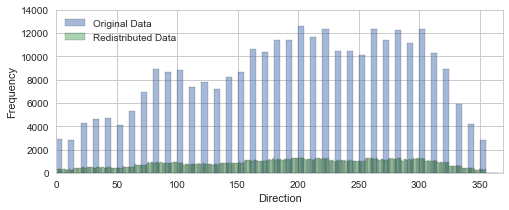

In [25]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

Redistribute upward, e.g. 0 -> [0,1]


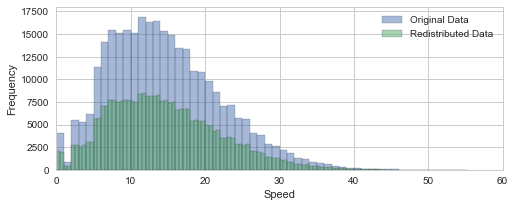

In [26]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.6 Generate (x,y) from (speed,dir)

In [27]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [28]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Overview

## 2.1 Data Overview

In [29]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: FM-12
Sampling time used: [0]
Speed redistribution info: Redistribute upward, e.g. 0 -> [0,1]


date          HrMn           dir         speed         month  \
count  4.283700e+04  42837.000000  42837.000000  42837.000000  42837.000000   
mean   2.012072e+07   1148.978687    193.687344     14.399415      6.518150   
std    1.413668e+04    693.172819     90.973544      7.305978      3.459189   
min    2.010010e+07      0.000000     -4.986563      0.000827      1.000000   
25%    2.011040e+07    500.000000    122.408747      8.811413      4.000000   
50%    2.012070e+07   1100.000000    202.352605     13.522387      7.000000   
75%    2.013100e+07   1800.000000    270.766267     18.982579     10.000000   
max    2.014123e+07   2300.000000    354.988717     55.290358     12.000000   

       dir_windrose             x             y  
count  42837.000000  42837.000000  42837.000000  
mean     191.330789     -2.265370     -2.883219  
std      102.782601     10.594855     11.620207  
min        0.000000    -55.267490    -48.815825  
25%      130.000000     -9.370271    -11.034577  
50%      200.000000     -2.148922     -3.085634  
75%      270.000000      5.042867      5.518479  
max      999.000000     36.027595     37.629249

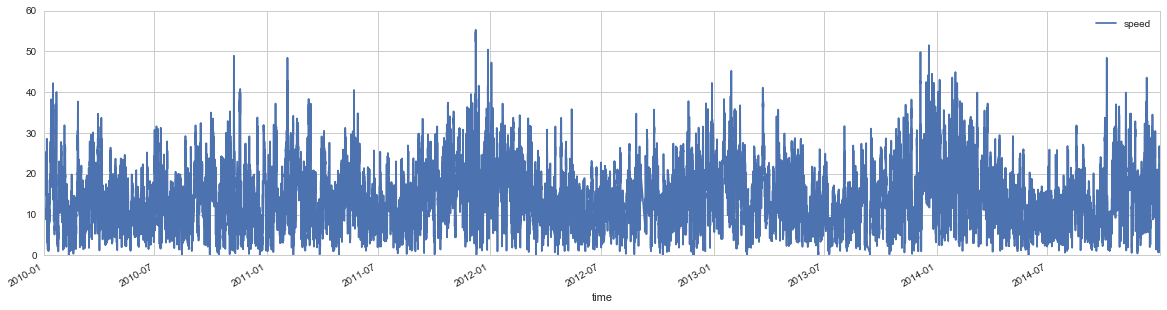

In [30]:
df.plot(y='speed',legend=True,figsize=(20,5))

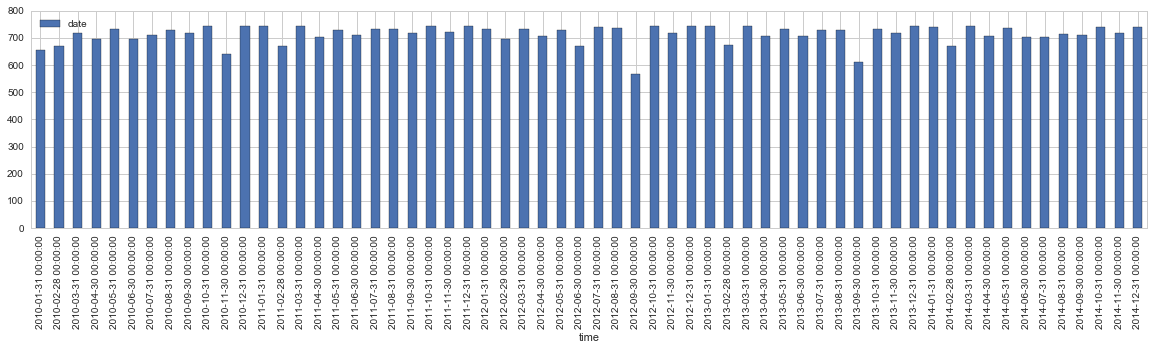

In [31]:
# df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))
df.resample('M').count().plot(y='date', kind='bar',figsize=(20,4))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


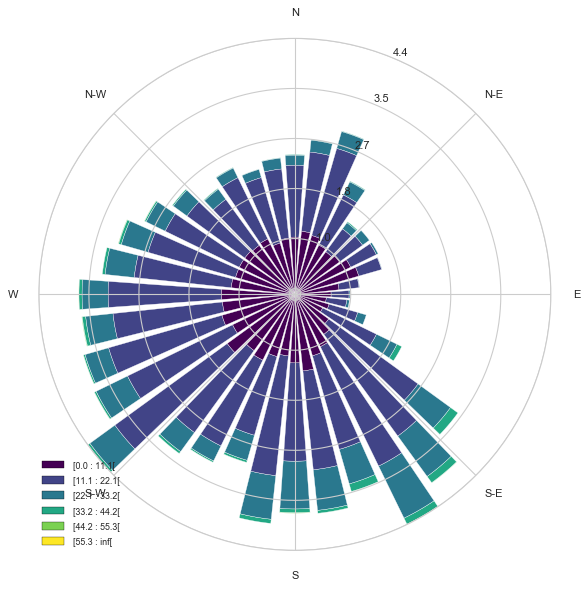

In [32]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [33]:
if len(df) > 1000000:
    bins=arange(0,362)
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min')
    
    df = df_all_years.sample(n=500000, replace=True)    
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min resmapled')
    plt_configure(legend=True, figsize=(20,4))

In [34]:
x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(df.speed)

# 1. Histogram comparison
fig = plt.figure()
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data', normed=True)             
plot(x, y_weibull, '-', color='black',label='Weibull')   
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF', legend=True)

# 2. CDF comparison
fig = plt.figure()
plot(log(x), log(-log(1-y_ecdf)),'o', label='ECDF')
plot(log(x), log(-log(1-y_cdf_weibull)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'}, figsize=(4,3))
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARsAAADSCAYAAAB6vWTpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzt3XlYVOX///HnsG+DoAmuICgqpoZ7KuK+lhtIQIT10yyz
8mOZC6ZmZi6ZZouaa59vqKmhFVq5JKamQILiirgRiigqiwLDPuf3hzEfcGGTmTMM9+O6vC5mOXNe
4+ibc87c9/1WSJIkIQiCoGVGcgcQBKF2EMVGEASdEMVGEASdEMVGEASdEMVGEASdEMVGEASd0Fqx
UavVzJ07Fz8/P4KCgkhMTCz1eHh4OD4+Pvj5+bF9+3bN/WvWrMHPzw9vb29+/PFHbcUTBEHHTLT1
wn/88Qf5+fls27aN2NhYFi9ezOrVqwEoKChg0aJFhIaGYmlpSUBAAP369ePKlSucPHmSH374gZyc
HDZu3KiteIIg6JjWik1MTAy9evUCwMPDg7Nnz2oeu3LlCk5OTtSpUweATp06cfz4cc6fP0/Lli15
++23ycrKYvr06dqKJwiCjmmt2GRlZWFjY6O5bWxsTGFhISYmJmRlZaFUKjWPWVtbk5WVRXp6OsnJ
yXz77bckJSXx1ltvsWfPHhQKxRP3ExMTo623IAhCOTp16lTh52qt2NjY2JCdna25rVarMTExeexj
2dnZKJVK7OzscHV1xczMDFdXV8zNzUlLS6NevXpl7qsyb1gXYmJiRKYK0MdMoJ+59DVTZWjtAnHH
jh05fPgwALGxsbRs2VLzWPPmzUlMTCQjI4P8/Hyio6Pp0KEDnTp14siRI0iSREpKCjk5OdjZ2Wkr
oiAIOqS1I5uBAwdy9OhR/P39kSSJhQsXsmvXLlQqFX5+fsycOZPx48cjSRI+Pj44Ojri6OjI8ePH
GTNmDJIkMXfuXIyNjbUVURAEHdJasTEyMmL+/Pml7mvevLnm5379+tGvX79HthMXhQXBMIlBfYIg
6IQoNoIg6IQoNoIg6ITWrtnUFmq1mvT09EfuEwShNFFsnlJ6ejr/FxaNtY0tANlZ93nOSfy1CsLD
xGlUNbC2sUVpa4/S1l5TdAShql599VVOnz4NQH5+Pp06dWLXrl2ax4OCgoiLi3tku8OHD7Nt2zaS
kpJ46aWXKry/nj17al73ypUrT5n+ycSvYC17+DTL3t4eIyNR42uKadOmVfvqA76+vixduvSJj/fs
2ZPo6Gjat29PTEwMnp6enDp1CoC8vDxu3LhB69atH9nOy8sLgKSkpGrNW13Ev3otKz7NCg2/yP+F
RT9yfUcQHtajRw+io6MBOHToEL6+vmRnZ5OZmcnJkyfp2rUrx48fJyAggFdeeYXg4GAKCgrYuXMn
n3/+OQBpaWlMnDgRX19fVq5cCcDMmTM1o/oPHz7MzJkzdfq+xJFNBTzuInBljlCKT7OEmmfp0qVl
HoVoQ5s2bbh69SqSJHH8+HHef/992rZty7Fjx4iPj8fT05M5c+awZcsW6tWrx4oVK/jpp580cw8B
VCoVS5cuxcrKisDAQPr376/T9/A4othUwOMuAr86onO5E0QFoSqMjIxo3bo1hw8fpn79+piZmeHh
4cGJEye4cOECgYGBzJkzhylTpgCQm5tLjx49cHZ21rxG69atNSsrtGvXjoSEhFL7kKNdnCg2FfQ0
RyeSJLHtuy+4cvEMHZxXiCIllKtnz56sWbOGF154AYBWrVqxf/9+4MFRdYMGDVi1ahVKpZIDBw5g
ZWXFzZs3NdtfuXKF7OxszM3NOX36NH5+fkRERHDnzh0Azp8/r/P3JK7Z6MBvO74jbNtazp2MoF+/
fqxfvx5JklCr1aSmppb6I8boCPDguk1MTAy9e/cGwMTEBKVSSdeuXTEyMuLDDz/kjTfewN/fny1b
tpRaVQGgTp06vPfee/j7+zN48GBatGiBr68v//3vf3nttddISUnR+XsSRzZa9v3337Nr+3rqOzZm
4IhAft2+hgkTJrB7926WLFnCr8f+EadnwiMaN25MfHx8qftWrVql+dnT0xNPT89Sj3t7e2t+DgsL
e+Q127VrV+or9GJHjx4FICQk5Kkyl0cc2WjRrl27+OCDD7BR2jHj03V4DRzF4cOH6du3L7/88gte
Xl4kXDonxugItYIoNloSERGBn58fFhYWvD1zKQ2buAAPfmP98ccffP7552RkZPDNoql898188nJz
ZE4sCNolio0WXLt2jRdffJH8/HzWr1+Pi9uzpR43MjJi6tSp7Nu3j0ZNXfhj9w98+I4PiVcvyJRY
ELRPFJtqlpF2h+DgYNLS0li7di2DBg3SPKZWq0lLS9NcDG7UqBEzF25kyOix3ExKYMmHE1ixYgVF
RUUyvgNB0A5xgbgaqbIz+WbRB6SkpPDJJ58wbtw4UlNTSz3+4/671KvvAMDtW0ko69Qj6M1gPLp4
sXrpTBYsWMCff/7Jpk2bSo2bEOTxuAGdT6u2TlkRxaaaFOTn88X8d0lKvMSLL77Ihx9++NjnWdko
NeN1sjLvae5v17Enc5dt4tDPqwgLC2PgwIGcPXuWzMxMzXNq6z9SOT08oPNp1eZvHLVWbNRqNfPm
zSM+Ph4zMzMWLFhQ6jd1eHg4K1euxMTEBB8fH80s1dGjR2v6TTVp0oRFixZpK2K1UavVfLtsJudP
RfFcFy/efffdMntdPYm1jS0bNmwgODiY9evXs3btWvKt3bC2sa3V/0jlJsd0k6ioKKZMmUKLFi2Q
JImMjAwmTZrEsGHDHvv85ORkLly48Nh1vfWFXrXfVSqVSJKk9e/7q5MkSYR+/zWRh36nZZuOjP/P
xxgbV/2ai0KhYO7cuXz//fcsW7aMaQu/F/Oqaqnnn3+eL774AngwFmbZsmW4uLjg7u7+yHMjIyO5
evVq7Sw2VWm/26hRI3Jychg3bhyFhYW8//77eHh4aCtitVi5ciXhv22jsVNzpn688t85J6qnes2m
TZvy+uuvs2rVKqKO7GHwyKDqCSvUWBYWFvj5+fHbb7+xadMmbt26xe3bt+nXrx+TJ09m7dq15Obm
0qFDB5RKJd988w2SJJGdna0pUnLTq/a7FhYWjB8/Hl9fX/755x8mTJjAnj17Ss1mfRxtt+DNyMjg
1q37ZGY9GAuTnXWP2FgVsbGxzJs3D2Wdurw2eQH3M1VkZ92jRV1bTaaS2965fRtjYzMK/z3wefh2
8eva2dnxwgsvsG7dOsK2b6BNh97k5mZrHqsqfWxVrI+ZgMd+ftWh5GdclosXL5KWllbq7ycjI4PI
yEi6deuGt7c3+fn5vPPOO3h5eTFo0CCSk5Oxs7Nj//79jB07Fnt7e37++Wc2btzIqFGjqiX/09Cr
9rsuLi44OzujUChwcXHBzs6OO3fu0LBhwzL3pe22pKmpqVxOu6g5nbmXYY6TkwOzZ89GoVAw+cMV
tGnroXns3r0UzRFZWloajql3sa1jj0LKx9jEDAfHRgCP3C5+3bp169KsWTNeeuklNm/ezJXzf9Op
R388PFpW+ZqNvrZv1bdMUDrXw5/908q8b1mhz7GwsJATJ05ocsTExGBpaUnv3r25ffs2W7ZswcbG
BrVaTadOnUhMTNT8nJ6eTlhYGFZWVqSkpNCxY0et/D1X9heF1opNx44dOXjwIMOGDSuz/a6VlRXR
0dGMHz+e0NBQLl68yLx580hJSSErK4v69etrK2KVqbIz2RB6kaioKJxcW/OMY+NSjx25nsadoovA
/77etq1T/j/Wh78ab9iqFyam2/n5h2/x6NpbO29GKFd21n3ZX0ulUvHjjz8yZswYcnJymD9/PomJ
iWzfvh1JkjAyMtJM4p0zZw779+/HxsaGGTNmyLKcxOPoVfvdMWPGEBwcTEBAAAqFgoULF5Z7CiWX
yxdikSTpsUX

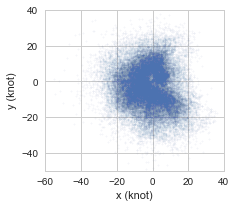

In [35]:
df.plot(kind='scatter', x='x', y='y', alpha=0.05, s=2)
plt.gca().set_aspect('equal')
plt_configure(figsize=(3.2,3.2),xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)

## 2.2. Overview by Direction

In [36]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [37]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAM0AAAB6CAYAAAAcc9ekAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAEOlJREFUeJzt3XtMU+f/B/B3KSJ8KQjIZEaDAxEdyKWKMqbijPchPwVx
Q+UScU5MlsFuUaeAAdTqpokxzA3BjKFMUcEYnW7DTPhNhgbEG6iz+FXcFCg313IRpM/3D8IZhQI9
pVgon1diwnn6lH6eyrvPc05PTwWMMQZCiMaM9F0AIUMNhYYQnig0hPBEoSGEJwoNITxRaAjhyaBC
09raivj4eHh7e8Pb2xt79+5FW1ubzvoDgEKhgL+/P+rr63vsExsbi8mTJ6v8i4+P77H/gwcPsHbt
Wnh4eMDPzw95eXl9D7YP69ev71ZDampqj/0LCwsREBAAd3d3rFy5Erdv3+Zu++WXX7B161atazl3
7hwCAwO7tR87dgyLFy+GWCxGZGQknjx5onJ7VlYWd/uqVatw7do1rWvQKWZAJBIJW7hwISsuLmZX
rlxhs2bNYklJSTrrzxhjCQkJ7Ntvv+21T3BwMPvmm29YVVUV908ul6vt29TUxHx9fVlMTAyTSqUs
KSmJubm5sUePHvU94F7MmTOHZWdnq9TQ2Niotm9FRQUTi8XswIEDTCqVsh07djBvb2/2/Plzrs/K
lSvZ1atXedfx+++/Mw8PDxYQEKDSfurUKebq6soyMjJYWVkZS0xMZPPmzeNqzM/PZ25ubuzcuXPs
8ePH7KuvvmKenp6soqKCdw26ZjChaW5uZh4eHiwnJ4dry8rKYj4+Pqytra3f/RljrKqqinl6erL6
+vpea5k5cybLzc3VqO7s7Gzm4+PDWlpauLaQkBAmkUg0ur86crmcOTs7M6lUqlH/gwcPshUrVnDb
SqWSzZ8/n6Wnp6vUGRISwqsOiUTCXF1d2bJly7qFZtmyZSwhIUHlMZcsWcIyMzMZY+0vThERESq3
T506lV28eJFXDQPBYJZnd+/eRVNTE2bOnMm1eXl5oaamBuXl5f3uDwAnTpyAWCzGqFGjeqxDJpOh
vr4eDg4OGtV9/fp1iMVijBgxgmubMWMGiouLNbq/OlKpFMbGxrC3t9eof3FxMWbMmMFtCwQCTJ8+
XaWGefPmobi4GPfv39e4joKCAqSlpWHRokXdbnvy5AmmTZum8piTJ0/G9evXAQDW1ta4efMmSkpK
wBhDVlYWGGNwdnbW+PEHisGEprKyEmZmZrCwsODaXnvtNQBARUVFv/sDwOXLlzFnzpxe65BKpRAI
BDh8+DDmzp2Ld999F0eOHIFSqVTbv6qqCmPGjFFps7W1RWVlZa+P01cNIpEIW7ZswezZs7F8+XJk
Z2f32F+TGkaNGgU3Nzfk5uZqXEd2djamT5+u9jZbW9tuz/PTp09RW1sLAAgLC4ObmxsCAwPh6uqK
7du3Y8+ePRq/GA0kgwlNU1MTRo4cqdJmYmICAGhpael3/7a2NpSWlsLJyanXOh4+fAgjIyPY29sj
OTkZERERSEpKQkpKCq+61dWgqbKyMjQ3N8PHxwcpKSlYsWIFYmJicP78+X7V4OTkhDt37mhdV2f+
/v5ITU3FrVu38PLlS2RmZqKkpAStra0A2oMsl8sRHx+PkydPIjw8HLGxsXjw4IFOHr8/jPVdgK6Y
mpp2+0/u2DYzM+t3//r6erS1tcHa2ppr++CDD1BUVMRtnz9/HmvWrIGfnx+srKwAAJMnT8bz58/x
/fff48MPP9S4DlNTU7Xj9PPzw9OnT7ltdcu4zz//HJGRkdwycsqUKXjy5AnS09Ph5+endQ1WVlZ4
+PCh2rr4ioyMREVFBYKDgwEAb7/9NlasWAG5XA4AiIuLw6xZs/D+++8DAFxdXVFaWorU1FRIJBKd
1KAtgwnN66+/jsbGRigUCohEIgDt+xcAYGdn1+/+AoEAAFSWWTt37kRzczO3PWbMGAgEAi4wHZyc
nFBdXY22tjYIhUKV2+zs7LjH7SCTydTWAADJycl4+fKl2ts6CIXCbvtdEydOxOXLl9X217SGtrY2
GBnpZnEycuRI7N69G7GxsWhqaoKNjQ2ioqIwfvx4AMDt27cREhKicp+pU6fi5s2bOnn8/jCY5dmU
KVNgZmam8spfWFgIW1tbtTvEfPtbW1vD2NgYdXV1XJudnR0mTJjA/TM2NsbOnTuxbt06lfveuXMH
b7zxRrfAAIBYLEZxcbFKEAoLCyEWi9WOc9y4cSqPqc5HH32Ebdu2qbSVlJTA0dFRbX+xWIzCwkJu
mzHGHaDorK6ujtvv66+vv/4ax44dg5mZGWxsbNDU1ISCggL4+PgAaH9upVKpyn2kUqnGBzcGksGE
xtTUFEFBQYiPj0dRURH++OMP7Nu3D2FhYVyf+vp67k1JTfp3JhAI4OLi0ufRowULFqCgoADJycko
Ly/HmTNnkJKSgk2bNgFof7WWyWTcDNVxZCkmJgZlZWU4dOgQbt26xS1btLFgwQKcOXMGp0+fRnl5
OdLS0nD27FlERkYCaF96yWQybkkWFBQEqVSK/fv3o6ysDAkJCWhoaIC/v7/K771//z7c3NwAAM3N
zZDJZH2+GdyTsWPHIikpCdeuXUNZWRmioqLg4OCA2bNnAwDWrl2L1NRUnD9/HuXl5UhOTsaVK1cQ
Hh6u7dOiMwLG9PchtM6v8rrQ0tKCtLQ0FBQUYMSIEfD19UVwcDC3pEhISADQ/geqSf+usrKy8ODB
A2zevLnXOq5du4asrCw8e/YM1tbW8Pf3x/z58wG0L3uioqKwceNGzJ07FwDw6NEjHDlyBI8fP4ad
nR1CQkLg7u7er+ciJycHFy5cQHV1Nezs7LBq1SrusHJpaSkSExOxfft2uLi4AGifDX/44QdUVlbC
3t4e69atU5mZGhsbsXHjRuzduxdjx45Fbm4uvvvuOxw4cKDP2efUqVMoLi7Gzp07uTalUonMzEzk
5uaitbUVnp6eCA8P545mMsbw888/49dff0VtbS3GjRuH1atXw9XVtV/PCx89HfnT65ubhYWF+nx4
3ioqKpiHhweTyWRa/46hNuYOx48fZ2FhYSptGzZs6PO5GKrj7a1ug1mevQp2dnYICAjAiRMn9F3K
K8UYw48//sgtMYH2N2WNjIxga2urx8r0g0LD06effoqffvqp1xM2Dc3Fixfh7OyMt956i2tzd3fH
oUOH9FiV/hjMIedXxcLCosc3CQ3V0qVLsXTpUpU2Y+Ph+6dDMw0hPFFoCOGJQkMITxQaQnii0BDC
E4WGEJ4oNITwRKEhhCeNQnPz5k2EhoYCAB4/fozVq1djzZo1iIuL4z5fkpmZicDAQLz33nv47bff
Bq5iQvSsz9AcPnwY27dvx4sXLwAAu3fvRnR0NDIyMsAYw6VLlyCTyZCeno7jx48jNTUV+/fv79fH
dQkZzPoMjb29PQ4ePMhtl5SUcFdw8fX1RX5+Pm7dugWxWAwTExNYWFjA3t4e9+7dG7iqCdGjPk8g
Wrx4Mf766y9umzHGffTX3NwccrkcCoVC5aou5ubmUCgUGhWg68/UDAXDbcyGNl7eZ911/oBWQ0MD
LC0tIRKJ0NDQoNLeOUS96fGDPgaqqKhoWI15qI63t6DzPnrm4uKCq1evAgDy8vLg5eUFd3d3FBUV
4cWLF5DL5SgrKxsUF3UjZCDwnmk2b96MmJgY7N+/H46Ojli8eDGEQiFCQ0OxZs0aMMbwySefdLuO
FiGGQu/XCBiKU3d/DLcxD9Xx9lY3vblJCE8UGkJ4otAQwhOFhhCeKDSE8EShIYQnCg0hPFFoCOGJ
QkMITxQaQnii0BDCE4WGEJ4oNITwRKEhhCcKDSE8UWgI4YlCQwhPFBpCeKLQEMIThYYQnig0hPBE
oSGEJwoNITx

## 2.3 Overview by Month

In [38]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOwAAADxCAYAAADIm1tRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzsnXd4HNW9v9/tVVppV7vq3bKKuzE2Nia4gG2qgeBLSAIk
JOGSBLjATSi/AA4dApeQQEIKCdwQE0poF0IzNgaDC2Ab27LVe12V7b3N7w+xi4VlW7JGxUTv8+h5
pJ2ZM7Oj+cw559uORBAEgSmmmOKEQDrRFzDFFFMMnynBTjHFCcSUYKeY4gRiSrBTTHECMSXYKaY4
gZgS7BRTnEBMCfbfgCnP3deHKcGOAytWrKC0tJQHHnhgyO0dHR2UlpZSWlqKzWYT9dzvvfce69ev
T/z92GOPMW/ePFHP4fF4WL58OW+//bao7U5xOFOCHSckEgkbN24ccts777wzZuf93//9X6xW65i1
7/F4+MlPfkJnZ+eYnWOKL5kS7Dgxb9482tvbOXjw4GHb3n77bUpLSyfgqkbHJ598wrp166iurp7o
S/m3YUqw40R5eTm5ubmH9aadnZ3s37+fNWvWHHbMxo0b+eY3v8ncuXM5/fTTefTRR4lEIontK1as
4M9//jPr169n4cKFzJ8/n5tvvhmPxwPAZZddxieffMKWLVsoLS2lvb09ceybb77J6tWrmTVrFhdd
dBG7d+9ObGtvb6e0tJTHHnvsqN/ppz/9KdOnT+fJJ588rnsyxciZEuw4smrVqsOGxe+88w5z5swh
IyNj0OfPP/8811xzDbNnz+bxxx/nu9/9Ln/961+55ZZbBu33xz/+EZfLxSOPPML111/Pv/71L554
4gkA1q9fT0VFBfPnz+f555/HYrEA4Pf7+fWvf811113Hb37zG/x+P9dee23iZWCxWHj++edZt27d
Ub/Phg0b+M1vfoPRaBzVfZli+Mgn+gL+nVizZg1/+ctfaGhooLi4GBgYDp911lmD9otGozz66KOc
c845CYPR0qVLSUpKYv369fzwhz+krKwMgIyMDB555BEkEglLly7lgw8+4Mknn2ThwoWcfvrp6PV6
tFotN954I3/729+AAavxQw89xNy5cwGIRCJce+211NfXU1ZWhlKpTGw7GtOnTxft3kwxPKZ62HFk
1qxZZGZm8u677wLQ1dXFvn37WL169aD9Ghsbsdlshw2TzznnHAA+++yzQW1KJJLE32azGRjoXd1u
95DXIZPJmD17duLv7OxsgCPuP8XkYUqw44hEIhk0LH7nnXeYPXs2mZmZg/ZzOp0AmEymQZ8nJSWh
VCoTc1QAjUZz2DlkMhlLly7l/vvvH/I6VCoVUumX//r477FY7Di/2RTjxZRgx5lVq1Zx4MAB2tvb
eeeddw4bDgOkpKQA0N/fP+hzl8tFKBRKbD8at9xyC9u3b8fhcIhz4VNMCqYEO87Mnz8fs9nMc889
x969ew8bDgMUFhaSmpp6WCDCm2++mWjjWOj1eu6++26am5sHWZanOLGZMjqNM1KplDPPPJOnn346
Maf9KjKZjGuuuYa7774bg8HAypUrqamp4bHHHmPNmjXDNvYsXboUs9nMnj170Gg0BIPBYR0XCoU4
ePAgGRkZh1mvp5hYpnrYCWDVqlWEw+Ehfa9xvvvd73Lvvfeyc+dOrr76ajZs2MD3v/99Hn744RGd
66677sLv99PX10d9ff2wjunp6eGSSy7hxRdfHNG5phh7JFM1nb5etLe3c/nll7N58+bEZx999BE/
+MEP2LRpEzk5ORN4dVOMlinBTjHFCcTUkHiKKU4gpgQ7xRQnEFOCnWKKE4gpt87XgFgsRjQaTVSW
EAQh8btEIhn0I5PJBoUyTgSbN2/m8ccfx+fzsXTpUm677bZB23t6erjtttuwWq1oNBoefvjhKWPZ
F0wZnSYxgiAQDocJhUKEw+HETzAYTHwWiURGHFIok8lQKBQoFAqUSiVKpTLxt0KhQKVSIZePzbu8
ra2Nb3/727z44ouYTCauuOIKrrrqKpYtW5bY53vf+x6rV6/m0ksv5R//+Afbt2/nt7/97Zhcz4nG
lGAnCYIgEAqF8Pl8eL1evF4vPp+PWCyGVCpN/MjlcuRyeUJoKpUq8XtcZFKplGg0yueff87cuXOR
SCQIgkAkEiEUChEMBg8TfVz4sVgMQRBQKBRotdpEto9WqxVFxH/961+xWq3ceuutAFitVpRKJamp
qQDYbDbOPvtstm/fjkQiIRQK0dnZSUFBwajP/XVgakg8QUQiEdxu92HilMvlKBQKNBoNJpMJg8GA
QqEY1bniwf0ymQyVSkVSUtIR9xUEAb/fj9PpxOv10tfXRzgcJhaLDRKxTqdDr9ePeHjd0tKCUqnk
Bz/4AT09PaxYsYLrr78+sb2trY2srCweeOABtm/fTmZmJnfcccfxffGvIVOCHUeCwSAOhwO73Y7X
600MTbVaLWazGYPBgEwmm9BrlEgkiR71UEKhEHa7HZfLRW9vL52dnUgkEgwGAykpKcO+9mg0ytat
W9mwYQM6nY6f/OQnvPLKK1x00UXAwIvswIED/OQnP+HWW2/lxRdf5JZbbuGZZ54Zk+97ojEl2DFE
EAR8Ph92ux2Hw0EwGEShUKDX68nOzj5qTzfZUCqVpKenk56eDgwYumw2G/39/bS2thKNRtHpdBiN
RgwGAyqVash20tLSWLx4cSJ1cOXKlezbty8hWLPZjFar5YwzzgDg3HPP5Z577hmHb3hiMCVYkREE
ITGUdDgcxGIxVCoVKSkppKenj3p4O1mQSqWkpaWRlpYGgNfrpaenh+7ubtra2lCpVKSmpmI2m1Eq
lYnjli9fzk033YTT6USv1/PRRx+xYsWKxPa8vDwyMzPZvHkzK1as4IMPPqCiomLcv99kZcroJBLR
aBS73Y7VaiUYDKJSqTCZTFgslkHJ4uN5PXGj03gPs4PBIFarFYfDQTgcxmAwYLFYSEpKQiKR8M9/
/pOnn36acDjM4sWLuf3227njjjtYsWIFK1eupLGxkfXr12O329HpdDzwwAMUFhaO63eYrEwJdpQE
AgF6enro6+tDKpWSkpJCdnb2hPekEynYQ/F4PHR0dOD1epHL5aSnp2MymcbMbfR1Z+quHQeCIOBw
OLBarXi9XtRqNfn5+RiNxgkPSphs6PV6SktLiUajdHV10d3dTUdHB0ajEYvFcphxa4qjM9XDjgBB
ELDZbHR0dBCNRtHr9eTm5qJWqyf60g5jsvSwQ2G32+ns7CQQCKDX68nJyUGn0030ZZ0QTPWww0AQ
BFwuF21tbYTDYVJTU8nNzZ10QjhRSE1NJTU1Fb/fT0tLC9XV1YmpxGR8+U0mpgR7DDweD21tbfj9
flJSUsjPz58SqkhoNBrKysrw+/00NTVx4MABTCYTWVlZgyzLU3zJlGCPgN/vp729HbfbTVJSErNm
zZpwQ9LXFY1GQ0VFBR6Ph+bmZiorK7FYLGRkZEwZp77C1N34CpFIhLa2Nmw2G1qtlvLy8sNq/04x
Nuj1embOnInNZqO9vZ3e3l4yMzNJT0+fMuZ9wZRgD8Fut9PS0oJUKqWkpITk5OSJvqR/S4xGI0aj
kc7OTrq6urDZbBQVFU3Nb5kSLDDQq7a0tOB0OjGbzWRnZ09IsMMUg8nKysJisVBfX8/BgwfJysr6
t+9t/+0Fa7fbaW5uRqFQTA1/ReTGG2/kwIEDiV7xmmuu4cwzz0xs3759Ow8++CDRaJTs7GwefPBB
DAbDYe3I5XLKysro6+tLTFX+nXvbf1s/7KG9anp6OllZWV+rN/dE+2FXrVrFCy+8MOSyItFolOXL
l/PUU09RXFzMww8/jFQq5cYbbzxqm9FolPr6erxe779tbztpxn3xRYQ/+OCDQZ+vWLFi0ELE4XCY
efPmYbPZEp9

# 3. Create input data and configuration

In [39]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [40]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11
 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28]


In [41]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 4. Kernel Density Estimation

In [42]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [43]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

In [45]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth, kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

bandwidth: 1.9 3249
[  4.21928334e-06   4.99537474e-06   5.92155017e-06   6.89977304e-06
   8.05242989e-06]


In [46]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x'+speed_unit_text,ylabel='y'+speed_unit_text)
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmUK3d9J/qpVVvv+3r7dvfFPrFDwNeQGw8TDCaecHDy
CI8XE5NkOMEcAgTeAOYRhjziPCDYJDPBLIY3B8ZDgPGAQ+YwLGfIxMbEBL8AhjhsXrv79qaWetFe
kmp/f0i/UlWpSqoqSd2tvvU5x8e3u/WrX6lU9dF3/XwpXdd1hAgRIsQZBX3SJxAiRIgQvURIciFC
hDjTCEkuRIgQZxohyYUIEeJMIyS5ECFCnGmEJBciRIgzjZDkQoQIcaYRklyIECHONEKSCxEixJlG
SHIhQoQ40whJLkSIEGcaIcmFCBHiTCMkuRAhQpxphCQXIkSIM42Q5EKECHGmEZJciBAhzjRCkgsR
IsSZRkhyIUKEONMISS5EiBBnGiHJhQgR4kwjJLkQIUKcaYQkFyJEiDONkORChAhxphGSXIgQIc40
QpILESLEmQZ70icQ4uSh6zokSYKiKGAYBhzHgaZpUBR10qcWIkTHoHRd10/6JEKcHERRRD6fx+Dg
IGRZBgAkk0mMjo5icHAQNE2HpBeirxFaclcwVFVFpVLBwcEBEokEFEUBx3HQdR26rkNVVSiKAkmS
QFEUGIYJSS9E3yEkuSsQuq5DURSoqgqKoqCqKtbW1qCqKliWhaZpKJfLiEQiYNnGLUJITxRF0DQN
hmHAMAxYlg1JL8SpReiuXmHQNA2yLIN87Ht7e8hkMjh37hx4nockSUilUqAoCrIsg2VZxONxxGIx
xONxMAxjOR45DkVRBtmxLNv0uhAhTgqhJXeFgLifqqoCABRFwc7ODjRNA8dxGBwchCRJiEaj4DgO
w8PDSCQSEEUR5XIZ+Xwe6XTaID1CfGYyUxQFuq5DFMWQ9EKcGoQkdwVA0zQoigJN00BRFIrFInZ3
dzE2NoahoSFsbW1ZXk9RFHRdB0VRiEajiEajGBsbg67rqFarqFQqyOVySKVS4DjOILxWpEfTtWol
WZYxNDQUkl6IY0NIcmccJI5GkgmpVAqFQgGLi4uGpeY1YkFRlEFmZtIrl8vI5XLY29sDz/MW95aQ
m67rqFQq2N/fNxIY5P+hpReilwhJ7ozC7p5KkoTt7W3wPI/V1VUjodBJssBMekDNYiSWXjabxd7e
HiKRiEF4ZA2xFO2WXkh6IXqBkOTOIOzuaTabRSqVwtTUFMbGxpqIzW7JERLyC5qmjXjd+Pi4QXrl
chmZTAbVahUAcHh4aJCj2dILSS9ELxCS3BmD2T3VNA17e3uoVCpYXl5GNBpten0vyz7MpAcAgiBg
f38fAHB0dARRFBGNRg1LLxqNhqQXousISe6MQNd1pNNpxONxRCIRVKtVbG9vI5FIYHV11SAPt7VA
bwkPqJEeTdOYmJgAULM4K5UKyuUyDg8PDdIjMT2vpMfzfFijF8IVIcmdAZDat2w2C5ZlUSwWcXBw
gLm5OQwPD7dc60QOQd3VdrDvRdM0EokEEokEgEYHBunCkCTJcGuJpUeOYSc9SZKgqipGR0fBcVxI
eiEMhCTX5yCdCwTEHVxdXQXP856OcVrqwRmGwcDAAAYGBgA0SK9cLmN/fx+yLDdZeoTMSMIjFouh
Wq1aOjJC0ruyEZJcn8LemlUqlVCpVDA4OIjFxUXPD7Xb604D8bUivXQ6DUVRDNIjRG+39GRZDknv
CkdIcn0Ic3IBANLpNLLZLKLRKEZGRjp+gE8rAdhJT1EUg/RKpZJRMkMsvUgkEpJeiJDk+gn22jdZ
lrGzswOKorC6uopkMun7mL2Kvx0HWJbF4OAgBgcHEYlEUKlUMDAwYBQnq6pqxPPi8bglQWEmPZLI
IMQXkt7ZQkhyfQJ77VuhUMDu7i4mJiYwMTFhKbLtBvqR+GiaNkgPqFl65XLZaEMzW3l20tM0zUjg
mEmPZVmwLBuSXh8jJLk+gKqqhqClruvY29tDsVjE0tKSUYMGBLPKzH2q5t/1G5zeN8uyGBoawtDQ
EICa5Uvc21wuB03TLJae2YIzk54syygWi5ieng5Jrw8Rktwphj25QGrfotEoLly4EBbE2tCOeDiO
A8dxFtIjll4mk4Gu6xZLj5AesQiJe0tRVGjp9RFCkjulMLunAJDJZJBOpzE9PY3R0dGu1beZY1Sd
HKcfQSSlhoeHoeu6xdLLZDIAgFgsZgiJmi1es6UXkt7pRkhypxDZbBYMwyASiUDTNCSTSVSrVdfW
LIIrhZx6AYqiwPM8eJ63kF65XEaxWIQoitjY2HC09ICQ9E4zQpI7RSDu6eHhIYaGhqCqKra3tzE4
ONi2NasTUBRlPKBmufN+QrfJ3Ux6HMchk8lgenoa5XIZgiDg8PAQNE0bhBeLxVxJD4BlPgbDMCHp
HSP6844+gzDXvpHsqSAInlqzCIJacrqu4/Lly5asIs/zkGUZHMf5Pt5JoVfEoeu6cU14nsfIyIgx
xpHU6BGdPHMiw2zBhaR3cghJ7oRhr31TVRWCIICmaV+tWUAwkisUCgCAwcFBLCwsQJZl7O/vQ5Ik
bG5ugmEY46F1mvFwpYKiKEQiEUQiEYyOjlpIr1gsGqRnlop3I72DgwOMjIwgkUgYCish6XUPIcmd
INxkyVmWxcjIiC+C8wuiWpLP50FRFMbHx6GqKnieN3pCx8bGIIoiKpUKCoUC0ul0S7nzswp7iY0T
nEjPfu1YlrW4t4T0qtWqkbmVJAkAmuZjhKQXHCHJnRDsrVmpVAq5XA4LCwsoFAqBbmqvlhxRCWZZ
Fqurq3jmmWeMB9n+fzLjgTy4RATTrPxLrBWzNNJZQpAQgNO1cxsKZM6ik8+dWPf2mbch6flHSHLH
DHvtmyzLBuFcuHDBkEoK+mC1W+fUKeHn+MSCsyv/2vXg7NJI5vffC3ixtjpBN/qB3YYCqapqzMcw
W3pmMgtJLzhCkjtG2N3TfD6PZDKJyclJjI+PGzdqJ6UgbuvM7qm9U6LVulawK/86qYSYA/H9il4Q
qPkLo1AoYGZmBrquuw4FCkkvOEKSOyaYdd90XUcymYQgCDh//rwxCIYgKMm5rbO7p/YyEfsDQUpK
/KKVSgjpHQWAXC7XVGd2JcOcvfU6FIjMxwhJrz1Ckusx3FqzYrEYVldXHQP3nZCcnZy8uqe9sFbM
KiFAbcZDKpVCtVo1OgrM2cdOylV6WQTda1fY6fhehgKReKh5KJCZ9BRFgSRJSCaTmJ+fB8dxVyTp
hSTXQ5gb64Ha8Jb9/X3MzMxgdHTUdV1QS8pMjuYZq07uqX3dcYA8YMQ1Ix0FpVIJBwcHlgebZB/9
oF8fXC8kag8NmEmv3VAgEvcjZS5mS4/jOAs5nkWEJNcDkNq3n/3sZ7hw4QIAIJlMQpIkrKysIBKJ
tFzfaXtWO/fU7Zy7ERP0CnNHgb241lyuYg/EnwROwpJrByfScxoKFIvFmjK3gNXSO+ukF5Jcl2Fv
rCcu2tDQEBYWFjyVWHTiroqiiLW1taZkRrt1Jw2nOrMrsVwlKOxDgcykBwDr6+stM99OpMcwjFGv
dxrukaAISa6LsNe+keb6+fl5Q97HK/ySnK7rKBQKqFQqOH/+vO9spn2/k27091uu0ktr6zRacu1A
SC8WiyGXy2FlZcWYhEY6WtwmoQGNe9kuFd+PpBeSXBdA3FNFUQz9sZ2dHei6jnPnzhnZRq/wa8kR
91TTNAwODvomOKfs6mlDq3KV/f19iKJouFp21d/TjuMgaD9DgcyT0OyJDFEUQVFUU0fGaUZIch3C
rTVrbGwMiqIEugH83PAkezo5OQmapg335KzD/tCm02lomgZJkixS506qv37RaxICeisu4HRsJ9Ij
AqLmGkdi6Zm

In [47]:
kde_cdf = cdf_from_pdf(kde_result)

# 5. GMM by Expectation-maximization

In [48]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

True


In [49]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight   mean_x   mean_y  sig_x  sig_y    corr
1  0.360  -10.823   -3.332  8.375  9.410  -0.165
2  0.323    0.404    6.933  7.233  8.081   0.121
3  0.317    4.742  -12.364  9.029  8.404  -0.137

GMM Plot Result
0.360257928233 [[-10.82343226  -3.3321174 ]] [ 7.96386785  9.76038604] -152.649861059
0.322679784803 [[ 0.40400751  6.93323745]] [ 7.01502336  8.27023018] 156.297947113
0.317062286964 [[  4.74194563 -12.36354121]] [ 8.02083724  9.37077597] -121.188605511


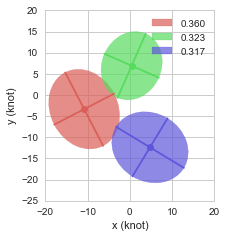

In [50]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax, xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)

In [51]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmUJFd9LvjFlmvtS1d1bd1V1VpGwgIJPYMfBwTy4QnL
sg1HWCDZjI+fNM82NtgYj63hjBHDwyw2z8bGAo9Hw8OGg0HgORxAMxwbCVsgZtiMsC2BoKtrz8rK
rKysXCKX2O78kXmjbkRGREYuUV1Zik+nT7cy88aNzIz48rd+P44QQhAiRIgQZxT81T6BECFChAgS
IcmFCBHiTCMkuRAhQpxphCQXIkSIM42Q5EKECHGmEZJciBAhzjRCkgsRIsSZRkhyIUKEONMISS5E
iBBnGiHJhQgR4kwjJLkQIUKcaYQkFyJEiDONkORChAhxphGSXIgQIc40QpILESLEmUZIciFChDjT
CEkuRIgQZxohyYUIEeJMIyS5ECFCnGmEJBciRIgzjZDkQoQIcaYRklyIECHONEKSCxEixJlGSHIh
QoQ40whJLkSIEGca4tU+gRBXH4QQKIoCTdMgCAIkSQLP8+A47mqfWogQPYMjhJCrfRIhrh7q9ToK
hQKGh4ehqioAIJVKYXx8HMPDw+B5PiS9EAON0JJ7HkPXdVSrVWSzWSSTSWiaBkmSQAgBIQS6rkPT
NCiKAo7jIAhCSHohBg4hyT0PQQiBpmnQdR0cx0HXdaytrUHXdYiiCMMwUKlUEI1GIYrHlwglvXq9
Dp7nIQgCBEGAKIoh6YU4tQjd1ecZDMOAqqqgX/ve3h4ODw+xtLSESCQCRVGQTqfBcRxUVYUoikgk
EojH40gkEhAEwXI8ehyO40yyE0Wx5XUhQlwthJbc8wTU/dR1HQCgaRp2dnZgGAYkScLw8DAURUEs
FoMkSRgdHUUymUS9XkelUkGhUMD+/r5JepT4WDLTNA2EENTr9ZD0QpwahCT3PIBhGNA0DYZhgOM4
lEol7O7uYmJiAiMjI9ja2rK8nuM4EELAcRxisRhisRgmJiZACEGtVkO1WsXR0RHS6TQkSTIJz4v0
eL5RraSqKkZGRkLSC3FiCEnujIPG0WgyIZ1Oo1gsYnFx0bTU/EYsOI4zyYwlvUqlgqOjI+zt7SES
iVjcW0puhBBUq1VkMhkzgUH/Di29EEEiJLkzCrt7qigKtre3EYlEsLq6aiYUekkWsKQHNCxGaunl
83ns7e0hGo2ahEfXUEvRbumFpBciCIQkdwZhd0/z+TzS6TTOnTuHiYmJFmKzW3KUhDoFz/NmvG5y
ctIkvUqlgsPDQ9RqNQDAwcGBSY6spReSXoggEJLcGQPrnhqGgb29PVSrVSwvLyMWi7W8PsiyD5b0
AECWZWQyGQBALpdDvV5HLBYzLb1YLBaSXoi+IyS5MwJCCPb395FIJBCNRlGr1bC9vY1kMonV1VWT
PNzWAsESHtAgPZ7nMTU1BaBhcVarVVQqFRwcHJikR2N6fkkvEomENXohXBGS3BkArX3L5/MQRRGl
UgnZbBZzc3MYHR31XOtEDt26q+1g34vneSSTSSSTSQDHHRi0C0NRFNOtpZYePYad9BRFga7rGB8f
hyRJIemFMBGS3ICDdi5QUHdwdXUVkUjE1zFOSz24IAgYGhrC0NAQgGPSq1QqyGQyUFW1xdKjZEYT
HvF4HLVazdKREZLe8xshyQ0o7K1Z5XIZ1WoVw8PDWFxc9H1Tu73uNBCfF+nt7+9D0zST9CjR2y09
VVVD0nueIyS5AQSbXACA/f195PN5xGIxjI2N9XwDn1YCsJOepmkm6ZXLZbNkhlp60Wg0JL0QIckN
Euy1b6qqYmdnBxzHYXV1FalUquNjBhV/OwmIoojh4WEMDw8jGo2iWq1iaGjILE7Wdd2M5yUSCUuC
giU9msigxBeS3tlCSHIDAnvtW7FYxO7uLqampjA1NWUpsu0HBpH4eJ43SQ9oWHqVSsVsQ2OtPDvp
GYZhJnBY0hNFEaIohqQ3wAhJbgCg67opaEkIwd7eHkqlEi5cuGDWoAHdWWVsnyr72KDB6X2LooiR
kRGMjIwAaFi+1L09OjqCYRgWS4+14FjSU1UVpVIJMzMzIekNIEKSO8WwJxdo7VssFsOlS5fCglgb
2hGPJEmQJMlCetTSOzw8BCHEYulR0qMWIXVvOY4LLb0BQkhypxSsewoAh4eH2N/fx8zMDMbHx/tW
38bGqHo5ziCCSkqNjo6CEGKx9A4PDwEA8XjcFBJlLV7W0gtJ73QjJLlTiHw+D0EQEI1GYRgGUqkU
arWaa2sWxfOFnIIAx3GIRCKIRCIW0qtUKiiVSqjX61hfX3e09ICQ9E4zQpI7RaDu6cHBAUZGRqDr
Ora3tzE8PNy2NasXnAVy7Pf5s6QnSRIODw8xMzODSqUCWZZxcHAAnudNwovH466kB8AyH0MQhJD0
ThAhyZ0SsLVvNHsqy7Kv1iyKfpHVoJJeUMRBCDF7ZCORCMbGxswxjrRGj+rksYkM1oILSe/qISS5
qwx77Zuu65BlGTzPd9SaBXRPToNKalcTHMchGo0iGo1ifHzcQnqlUskkPVYq3o30stksxsbGkEwm
TYWVkPT6h5DkriLcZMlFUcTY2FhHBBciONhLbJzgRHr1eh3VahXFYtGcj8G6t5T0arWamblVFAUA
WuZjhKTXPUKSu0qwt2al02kcHR1hYWEBxWKxq4u6F4vs4OAAxWIRsVjMHE0YooFurWM6H4MlPaeh
QGwWnX7v1Lq3z7wNSa9zhFfyCcNe+6aqKra3tyGKIi5dumRKJZ2U20lvsFKphHPnzll6QavVqsXd
6kfiIyi32I+11Qv60Q/sNhRI13VzPgZr6bFkFpJe9whJ7gRhd08LhQJSqRSmp6cxOTlpXqi9WGSd
rKtUKtje3gbHcVhaWjJnNlBVYdoHSqXLo9GoSXqsoKVfDOqNGASBsvMxisUiZmdnQQhxHQoUkl73
CEnuhMDqvhFCkEqlIMsyLl68aA6CoQg6gUAIQS6XQzabxfz8PFKplGNbF7256LwGauWxgpaU9FjF
jxCdgc3e+h0KRC3rkPTaIyS5gOHWmhWPx7G6uurYmtULydHYjhs0TcPu7i40TTOzt6lUqq214qbi
W6lUkE6noWmaq+LHSSDI7HDQrrDT8f0MBaKWNTsUiCU9TdOgKApSqRTm5+chSdLzkvRCkgsQbGM9
0BjekslkMDs7i/Hxcdd1fsjKbZ3XzU7d05GRESwuLpruZjcXvJO2W6VSQaVSQT6fN/tA2eb3oDGo
N64fErUPBWJJr91QIBr3o2UurKUnSZKFHM8iQpILALT27ZlnnsGlS5cAAKlUCoqiYGVlBdFo1HN9
v+vW7O4pbVC3v6aXmCCr+MG2RNEhNTzPIxqNmhbGIGVvr4Yl1w5OpOc0FCgej7dkbgGrpXfWSW9w
rrQBgb2xXpZlpNNpjIyMYGFhwVewvp8xOV3XsbOzY3FPndb1E2xLFNsdQLs4NjY2zPIJNpMYonvY
wwks6QHAlStXTKl4+1AgwJn0BEEw6/UGmfRCkusj7LVvtLnezXryQj9IjrqndO6Dn7GEvezvdV7R
aBQjIyOQZRkXLlwwXS2aSew1cxskTqMl1w6U9OLxOI6OjrCysmJOQstkMp6T0IDja9kuFT+IpBeS
XB9A3VNN00z9sZ2dHRBCsLS0ZMat/KJXd5UQgsPDQ2Qyma7GEgZ9AbPlE4A1vmSfv+p0AzqBZigH
EUGSKD12J0OB2Elo9kRGvV4Hx3EtHRmnGSHJ9Qi31qyJiQlomtbVBdDtBU8TFtvb277jf6cB9viS
0w14tTO3QZIQEKy4gNOxnUiPCoiynzn93O0lQuzM28PDQ4yNjSEej5tkeZqILyS5HmCvfUun0ygW
i1hcXEQymTz

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARYAAADPCAYAAAAwC/4cAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztvXtUU3e6//8OOwRpiFJaBW+gIljxyuULTqs40nrsdNWR
NVQxVma1tWKp2lo9CLUqzgyCjmPXOq23dep0pjJLi9I55+jqmtMZtUdaba1gYxW5KNZ4F9TyaxIv
gWT//og7JmFfk53757VW1iLZ+/PJh0vePM/zeT7Po6BpmgaBQCDISIS/F0AgEEIPIiwEAkF2iLAQ
CATZIcJCIBBkhwgLgUCQHSIsBAJBdpT+XoA7NDY2+nsJBIKdzMxM0fd+rzsEqyWW87pKpcK4cePk
WJZfCUphAYC9lfVem9tgNEATo/Ha/IEC+T49Z87qXEn3Wy2xiE+s5rx+89K7ni4pICCuEIFAkB0i
LAQCQXaIsBAIBNkhwkIgEGSHCAuBQJAdIiwEAkF2iLAQCATZCdo8FgIh3LBarVi3bh1aW1uhUqlQ
WVmJpKQk+/XDhw9j69atUCqVKCgowJw5cwTHVFVVYfjw4dBqtQCAv/71r/j8888BAFOnTsWSJUtA
0zRyc3MxbNgwAMDEiROxYsUK3rUSYSEQgoSDBw/CbDajtrYWOp0OGzZswPbt2wEA3d3dqK6uRl1d
HaKjo6HVapGXl4eTJ0+yjrlz5w5WrlyJixcvYsGCBQCAy5cvY//+/di3bx8iIiKg1Wrx3HPPITo6
GmPGjMGOHTtEr5W4QgRCkNDY2IgpU6YAsFkNZ86csV9rb29HYmIi+vXrB5VKhczMTJw4cYJzjMlk
wtKlSzFr1iz7HAkJCdi5cycoioJCoUBPTw+ioqLQ1NSEmzdvoqioCAsXLsSFCxcE10qEhUAIEoxG
I2JiYuzPKYpCT0+P/ZpG8+jYglqthtFo5BwzdOhQTJgwwWn+yMhIxMXFgaZpbNy4EWlpaRg+fDj6
9++P4uJi1NTUYNGiRSgtLRVcK3GFCIQgISYmBiaTyf7carVCqVSyXjOZTNBoNLxj2Hjw4AFWrVoF
tVqNiooKAMDYsWNBURQAICsrCx0dHaBpGgqFgnMeYrEQCEFCRkYG6utth291Oh1SU1Pt15KTk6HX
69HV1QWz2YyGhgakp6fzjnGFpmm8+eabGDVqFH7/+9/bxWTLli345JNPAAAtLS0YOHAgr6gAxGIh
EIKG6dOn4+jRo5g7dy5omkZVVRUOHDiAu3fvorCwEOXl5ViwYAFomkZBQQHi4+NZx3Bx8OBBfPfd
dzCbzfjqq68AAMuXL0dxcTFKS0tx5MgRUBSF6mru09kMimBs/9HY2EjKJsgA+T49Z87qXEn1WBob
GwXLJkiZL1AhFgvBI9ru3ENqXLS/lxFUdN4/7+8leB0iLIRetN2559H9RGj4uUA/y3ltmO+W4VWI
sIQ5bCKSPG6oZ3OevgyACEw441Nh6e7uxqpVq3D16lWYzWaUlJRg5MiRKC8vh0KhQEpKCioqKhAR
QTarvIWjkFgsClCU50LiSvK4oWg/fZm4SWGMT4Vl//79iI2NxaZNm9DV1YX8/Hw89dRTWLZsGXJy
crB27VocOnQI06dP9+WyghqpboujiBgMBqekKjkh4hLe+FRYnn/+ecyYMQOAbc+coig0NTUhOzsb
AJCbm4ujR48SYeHBG66LtyDiEr74VFjUajUAW/rxW2+9hWXLlmHjxo32ZBu1Wg2DwSBqLoNR3H3u
4u35pXDl3qNkpIHJT/S6LvZnxoYnY8UwYFgsrrffRnOnEUOi/ZfZEEi/z3DA58Hb69evY/HixZg3
bx5mzpyJTZs22a+ZTCb07dtX1DzezL8IlPwOxjrxRhwE8K4r5Ihmogbtpy/jutk/Ad1A+X2GEz6N
kt66dQuvvfYaSktL8dJLLwEA0tLScPz4cQBAfX09srKyfLmkgKTtzj27qCSPGxqwro4UQuF7IIjH
p8KyY8cO/Pzzz9i2bRuKiopQVFSEZcuW4cMPP0RhYSG6u7vtMZhwJdQExZHkcUMlB5sJwYlPXaHV
q1dj9erVvV7/29/+5stlBCSOH7hQExRC+EES5AIARyvFF5w2/AQA6LFYoDT0uD3POM3jksckjxuK
ttOXyS5RiEOExc94U1QYAXElOSUBgOfB29Pnbti/dkdkCKELERY/4Q3Xh01IGBHxBszc7edu2N+b
CAwBIMLiF+S0UlzFxJtCwoWrwIgRF5I0F9oQYfExnopKIAgJF8kpCWh3cI8473uYkUsIXYiw+BBP
RMVRUOQQk1OmTlhoCyjTfdFjJqj7i7pPrNVCCF2IsPgAfwvKKVNnr9dSkwZIzkg9pe+wf80lMmKt
FkJoQ4TFy7grKp4KiquYpCYNkDyHK8wcbfoOnDJ18lowxGrh5oLxCue1Yb5bhlchwuJFPBUVqYLi
DTFhIzVpAK+4EKuFny7L0/5egtchwuIlfCUqvhITV5j3OaXvEB17IYQPRFi8gC9ExVFQ3BETXfdN
WJQWUN13Rd0/MTKedy1s4kLcofCFCIuM+FJQpIqJrvum0/PRgwaIzrxtvtZhH+8qMIxb5Apxh+TH
arVi3bp1aG1thUqlQmVlJZKSkuzXDx8+jK1bt0KpVKKgoABz5swRHFNVVYXhw4dDq9UCAPbu3YtP
P/0USqUSJSUlmDZtGu7fv4/S0lLcvn0barUaGzduRFxcHO9aSXFZmfC2qJwydeKUqROpSQNEi4qu
+6b9MXrQAKeHFBzHuAoUYBMXtp0ngrwcPHgQZrMZtbW1WLFiBTZs2GC/1t3djerqanz88ceoqalB
bW0tbt26xTnmzp07eP3113H48GH7HJ2dnaipqcGnn36KP//5z3j//fdhNpuxZ88epKamYvfu3cjP
z8e2bdsE10qExUNca6dIQYqoAOKsFC4xkQM+cXEHUkJBGo2NjZgyZQoAYOLEiThz5oz9Wnt7OxIT
E9GvXz+oVCpkZmbixIkTnGNMJhOWLl2KWbNm2ef44YcfkJ6eDpVKBY1Gg8TERLS0tDjNkZubi2++
+UZwrURY3MTTYkxiRIWxUgBhUWHEBICsYuIKn7hIsVpIaQjpGI1GxMTE2J9TFIWenh77NUe3Vq1W
w2g0co4ZOnQoJkyY0Gt+rjmY18WWjyUxFol4enhQbivFUUzcpZW+5PR8lCKR9/7Rgwag+ZpzXIUt
1pKckoDT526QAK5MxMTEwGQy2Z9brVYolUrWayaTCRqNhneM0Pxsc4gtH0ssFhEw1omn1d3kFBVX
d0csrfQl++NSn1t2UUnrP8D+cLzHVXRc1+AJpKKcNDIyMlBfb+tZrtPpkJqaar+WnJwMvV6Prq4u
mM1mNDQ0ID09nXeMK+PHj0djYyMePHgAg8GA9vZ2pKamIiMjA0eOHAFgKx8rprc0sVh4kKu0gZQs
WiFRcfwwixUUR3FI6/9oDNeukOM9Zzs70Epf6mXFsFktBO8yffp0HD16FHPnzgVN06iqqsKBAwdw
9+5dFBYWory8HAsWLABN0ygoKEB8fDzrGC769++PoqIizJs3DzRN45133kFUVBS0Wi3Kysqg1WoR
GRmJzZs3C65VQdO0/3oyuEljYyP2VtZ7bX6D0YDrZpvmehoLkGqlAMKiIkZQuMTEEbHbzWc7bQLi
Ki7N1zqctp8ZV8gxp6VdhCvU7uWKct6s0j9nda6o/+AMjY2N+Lvqa87rvzFPljRfoEJcIRfa7tyz
9/HxtajwbSWLFRVH94VxbTyFmYPNLXK0oNjWnpySwFnJzhHiEoUWxBVygPnjHpj8hGclG2W0UgBx
oiLGQvGEtP4D7JYLg1zuEKnPEnr4xWI5deoUioqKAAB6vR5arRbz5s1DRUUFrFarP5YkW1U3ua0U
oQCtNywUPvi

## Goodness-of-fit Statistics

In [52]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.974  0.013      0.022  2.779026e-09      0.041       0.176

# 6. GMM by Optimization

In [53]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

square_error


In [54]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -19.989545183351275
     jac: array([  2.00869989e+00,   0.00000000e+00,   2.38418579e-07,
         0.00000000e+00,  -2.38418579e-07,   0.00000000e+00,
         2.00870180e+00,   0.00000000e+00,   2.38418579e-07,
         0.00000000e+00,   2.38418579e-07,  -2.38418579e-07,
         2.00870109e+00,   0.00000000e+00,   2.38418579e-07,
         0.00000000e+00,   0.00000000e+00,  -4.76837158e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1493
     nit: 74
    njev: 74
  status: 0
 success: True
       x: array([  0.68021985,  -6.24015497,  -4.37794586,   9.87816628,
        10.26082602,  -0.20794799,   0.20103273,   2.05324664,
         9.02618512,   6.68505876,   6.79198857,  -0.10846576,
         0.11874742,  10.22653484, -12.93840948,   6.99258163,
         6.41581982,  -0.3380959 ])

## 6.1 GMM Result

In [55]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x   mean_y  sig_x   sig_y    corr
1  0.680  -6.240   -4.378  9.878  10.261  -0.208
2  0.201   2.053    9.026  6.685   6.792  -0.108
3  0.119  10.227  -12.938  6.993   6.416  -0.338

GMM Plot Result
0.680219849499 [[-6.24015497 -4.37794586]] [  8.94454165  11.08412803] -140.180006599
0.201032732116 [[ 2.05324664  9.02618512]] [ 6.35871503  7.09844085] -139.161892459
0.118747418385 [[ 10.22653484 -12.93840948]] [ 5.41999252  7.7899052 ] -127.849218416


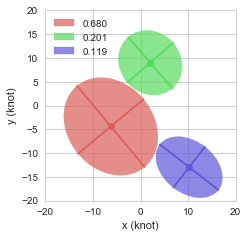

In [56]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm, ax=ax, xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)

## 6.2 Goodness-of-fit statistics

In [57]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.981  0.015      0.057  2.082816e-09      0.035       0.152

In [58]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z, xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z, xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,  xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmQLHldL/rJrbKW3pfTfXo7p7vPMMgBZA6jYMwFhiHm
DY48FeEig3oNY7iiPFERQyfw6vh4yqJcJB4P5N43EigEwXovj+WFIZsOSzw2GZdhmTl9ll6qq6u6
u7qWrCW33/sj65f9y6zMrKwl+3T15IcgTk93/fKXWZX5qe/6+XKEEIIYMWLEOKPgb/UJxIgRI0aU
iEkuRowYZxoxycWIEeNMIya5GDFinGnEJBcjRowzjZjkYsSIcaYRk1yMGDHONGKSixEjxplGTHIx
YsQ404hJLkaMGGcaMcnFiBHjTCMmuRgxYpxpxCQXI0aMM42Y5GLEiHGmEZNcjBgxzjRikosRI8aZ
RkxyMWLEONOISS5GjBhnGjHJxYgR40wjJrkYMWKcacQkFyNGjDONmORixIhxphGTXIwYMc40YpKL
ESPGmUZMcjFixDjTEG/1CcS49SCEQFVV6LoOQRAgSRJ4ngfHcbf61GLE6BscIYTc6pOIcevQbDZR
KpUwOjoKTdMAANlsFpOTkxgdHQXP8zHpxRhqxJbcUxiGYaBer6NQKCCTyUDXdUiSBEIICCEwDAO6
rkNVVXAcB0EQYtKLMXSISe4pCEIIdF2HYRjgOA6GYWBjYwOGYUAURZimiVqtBlmWIYrHtwglvWaz
CZ7nIQgCBEGAKIox6cU4tYjd1acYTNOEpmmgH/vu7i4ODw+xsrKCRCIBVVWRy+XAcRw0TYMoikin
00ilUkin0xAEwXE8ehyO42yyE0Wx7XUxYtwqxJbcUwTU/TQMAwCg6zq2t7dhmiYkScLo6ChUVUUy
mYQkSRgfH0cmk0Gz2UStVkOpVMLe3p5NepT4WDLTdR2EEDSbzZj0YpwaxCT3FIBpmtB1HaZpguM4
VCoV7OzsYGpqCmNjY9jc3HS8nuM4EELAcRySySSSySSmpqZACEGj0UC9XsfR0RFyuRwkSbIJL4j0
eN6qVtI0DWNjYzHpxTgxxCR3xkHjaDSZkMvlUC6Xsby8bFtqYSMWHMfZZMaSXq1Ww9HREXZ3d5FI
JBzuLSU3Qgjq9Try+bydwKD/xpZejCgRk9wZhds9VVUVW1tbSCQSWF9ftxMK/SQLWNIDLIuRWnrF
YhG7u7uQZdkmPLqGWopuSy8mvRhRICa5Mwi3e1osFpHL5XDu3DlMTU21EZvbkqMk1C14nrfjddPT
0zbp1Wo1HB4eotFoAAD29/dtcmQtvZj0YkSBmOTOGFj31DRN7O7uol6vY3V1Fclksu31UZZ9sKQH
AIqiIJ/PAwAODg7QbDaRTCZtSy+ZTMakF2PgiEnujIAQgr29PaTTaciyjEajga2tLWQyGayvr9vk
4bcWiJbwAIv0eJ7HzMwMAMvirNfrqNVq2N/ft0mPxvTCkl4ikYhr9GL4Iia5MwBa+1YsFiGKIiqV
CgqFAhYWFjA+Ph641oscenVXO8G9F8/zyGQyyGQyAI47MGgXhqqqtltLLT16DDfpqaoKwzAwOTkJ
SZJi0othIya5IQftXKCg7uD6+joSiUSoY5yWenBBEDAyMoKRkREAx6RXq9WQz+ehaVqbpUfJjCY8
UqkUGo2GoyMjJr2nNmKSG1K4W7Oq1Srq9TpGR0exvLwc+qH2e91pIL4g0tvb24Ou6zbpUaJ3W3qa
psWk9xRHTHJDCDa5AAB7e3soFotIJpOYmJjo+wE+rQTgJj1d123Sq1ardskMtfRkWY5JL0ZMcsME
d+2bpmnY3t4Gx3FYX19HNpvt+phRxd9OAqIoYnR0FKOjo5BlGfV6HSMjI3ZxsmEYdjwvnU47EhQs
6dFEBiW+mPTOFmKSGxK4a9/K5TJ2dnYwMzODmZkZR5HtIDCMxMfzvE16gGXp1Wo1uw2NtfLcpGea
pp3AYUlPFEWIohiT3hAjJrkhgGEYtqAlIQS7u7uoVCq4cOGCXYMG9GaVsX2q7O+GDV7XLYoixsbG
MDY2BsCyfKl7e3R0BNM0HZYea8GxpKdpGiqVCubm5mLSG0LEJHeK4U4u0Nq3ZDKJS5cuxQWxLnQi
HkmSIEmSg/SopXd4eAhCiMPSo6RHLULq3nIcF1t6Q4SY5E4pWPcUAA4PD7G3t4e5uTlMTk4OrL6N
jVH1c5xhBJWUGh8fByHEYekdHh4CAFKplC0kylq8rKUXk97pRkxypxDFYhGCIECWZZimiWw2i0aj
4duaRfFUIacowHEcEokEEomEg/RqtRoqlQqazSauX7/uaekBMemdZsQkd4pA3dP9/X2MjY3BMAxs
bW1hdHS0Y2tWPzgL5Djo82dJT5IkHB4eYm5uDrVaDYqiYH9/HzzP24SXSqV8SQ+AYz6GIAgx6Z0g
YpI7JWBr32j2VFGUUK1ZFIMiq2ElvaiIgxBi98gmEglMTEzYYxxpjR7VyWMTGawFF5PerUNMcrcY
7to3wzCgKAp4nu+qNQvonZyGldRuJTiOgyzLkGUZk5OTDtKrVCo26bFS8X6kVygUMDExgUwmYyus
xKQ3OMQkdwvhJ0suiiImJia6IrgY0cFdYuMFL9JrNpuo1+sol8v2fAzWvaWk12g07MytqqoA0DYf
Iya93hGT3C2CuzUrl8vh6OgIS0tLKJfLPd3U/Vhk+/v7KJfLSCaT9mjCGBZ6tY7pfAyW9LyGArFZ
dPq5U+vePfM2Jr3uEd/JJwx37Zumadja2oIoirh06ZItlXRSbid9wCqVCs6dO+foBa3X6w53axCJ
j6jc4jDWVj8YRD+w31AgwzDs+RispceSWUx6vSMmuROE2z0tlUrIZrOYnZ3F9PS0faP2Y5F1s65W
q2Frawscx2FlZcWe2UBVhWkfKJUul2XZJj1W0DIshvVBjIJA2fkY5XIZ8/PzIIT4DgWKSa93xCR3
QmB13wghyGazUBQFFy9etAfBUESdQCCE4ODgAIVCAYuLi8hms55tXfThovMaqJXHClpS0mMVP2J0
BzZ7G3YoELWsY9LrjJjkIoZfa1YqlcL6+rpna1Y/JEdjO37QdR07OzvQdd3O3maz2Y7Wip+Kb61W
Qy6Xg67rvoofJ4Eos8NRu8Jexw8zFIha1uxQIJb0dF2HqqrIZrNYXFyEJElPSdKLSS5CsI31gDW8
JZ/PY35+HpOTk77rwpCV37qgh526p2NjY1heXrbdzV5ueC9tt1qthlqthmKxaPeBss3vUWNYH9ww
JOoeCsSSXqehQDTuR8tcWEtPkiQHOZ5FxCQXAWjt2+OPP45Lly4BALLZLFRVxdraGmRZDlw/6Lo1
t3tKG9Tdr+knJsgqfrAtUXRIDc/zkGXZtjCGKXt7Kyy5TvAiPa+hQKlUqi1zCzgtvbNOesNzpw0J
3I31iqIgl8thbGwMS0tLoYL1g4zJGYaB7e1th3vqtW6QYFui2O4A2sVx48YNu3yCzSTG6B3ucAJL
egBw7do1WyrePRQI8CY9QRDser1hJr2Y5AYId+0bba73s56CMAiSo+4pnfsQZixhP/sHnZcsyxgb
G4OiKLhw4YLtatFMYr+Z2yhxGi25TqCkl0qlcHR0hLW1NXsSWj6fD5yEBhzfy26p+GEkvZjkBgDq
nuq6buuPbW9vgxCClZUVO24VFv26q4QQHB4eIp/P9zSWMOobmC2fAJzxJff8Va8H0As0QzmMiJJE
6bG7GQrETkJzJzKazSY4jmvryDjNiEmuT/i1Zk1NTUHX9Z5ugF5veJqw2NraCh3/Ow1wx5e8HsBb
nbmNkoSAaMUFvI7tRXpUQJR9z+n77i4RYmfeHh4eYmJiAqlUyibL00R8Mcn1AXftWy6XQ7lcxvLy
MjKZzIl2LgC

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARYAAADPCAYAAAAwC/4cAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztvXtUU3e6//8OOwRpiFJaBW+gIljxyuULTqs40nrsdNWR
NVQxVma1tWKp2lo9CLUqzgyCjmPXOq23dep0pjJLi9I55+jqmtMZtUdaba1gYxW5KNZ4F9TyaxIv
gWT//og7JmFfk53757VW1iLZ+/PJh0vePM/zeT7Po6BpmgaBQCDISIS/F0AgEEIPIiwEAkF2iLAQ
CATZIcJCIBBkhwgLgUCQHSIsBAJBdpT+XoA7NDY2+nsJBIKdzMxM0fd+rzsEqyWW87pKpcK4cePk
WJZfCUphAYC9lfVem9tgNEATo/Ha/IEC+T49Z87qXEn3Wy2xiE+s5rx+89K7ni4pICCuEIFAkB0i
LAQCQXaIsBAIBNkhwkIgEGSHCAuBQJAdIiwEAkF2iLAQCATZCdo8FgIh3LBarVi3bh1aW1uhUqlQ
WVmJpKQk+/XDhw9j69atUCqVKCgowJw5cwTHVFVVYfjw4dBqtQCAv/71r/j8888BAFOnTsWSJUtA
0zRyc3MxbNgwAMDEiROxYsUK3rUSYSEQgoSDBw/CbDajtrYWOp0OGzZswPbt2wEA3d3dqK6uRl1d
HaKjo6HVapGXl4eTJ0+yjrlz5w5WrlyJixcvYsGCBQCAy5cvY//+/di3bx8iIiKg1Wrx3HPPITo6
GmPGjMGOHTtEr5W4QgRCkNDY2IgpU6YAsFkNZ86csV9rb29HYmIi+vXrB5VKhczMTJw4cYJzjMlk
wtKlSzFr1iz7HAkJCdi5cycoioJCoUBPTw+ioqLQ1NSEmzdvoqioCAsXLsSFCxcE10qEhUAIEoxG
I2JiYuzPKYpCT0+P/ZpG8+jYglqthtFo5BwzdOhQTJgwwWn+yMhIxMXFgaZpbNy4EWlpaRg+fDj6
9++P4uJi1NTUYNGiRSgtLRVcK3GFCIQgISYmBiaTyf7carVCqVSyXjOZTNBoNLxj2Hjw4AFWrVoF
tVqNiooKAMDYsWNBURQAICsrCx0dHaBpGgqFgnMeYrEQCEFCRkYG6utth291Oh1SU1Pt15KTk6HX
69HV1QWz2YyGhgakp6fzjnGFpmm8+eabGDVqFH7/+9/bxWTLli345JNPAAAtLS0YOHAgr6gAxGIh
EIKG6dOn4+jRo5g7dy5omkZVVRUOHDiAu3fvorCwEOXl5ViwYAFomkZBQQHi4+NZx3Bx8OBBfPfd
dzCbzfjqq68AAMuXL0dxcTFKS0tx5MgRUBSF6mru09kMimBs/9HY2EjKJsgA+T49Z87qXEn1WBob
GwXLJkiZL1AhFgvBI9ru3ENqXLS/lxFUdN4/7+8leB0iLIRetN2559H9RGj4uUA/y3ltmO+W4VWI
sIQ5bCKSPG6oZ3OevgyACEw441Nh6e7uxqpVq3D16lWYzWaUlJRg5MiRKC8vh0KhQEpKCioqKhAR
QTarvIWjkFgsClCU50LiSvK4oWg/fZm4SWGMT4Vl//79iI2NxaZNm9DV1YX8/Hw89dRTWLZsGXJy
crB27VocOnQI06dP9+WyghqpboujiBgMBqekKjkh4hLe+FRYnn/+ecyYMQOAbc+coig0NTUhOzsb
AJCbm4ujR48SYeHBG66LtyDiEr74VFjUajUAW/rxW2+9hWXLlmHjxo32ZBu1Wg2DwSBqLoNR3H3u
4u35pXDl3qNkpIHJT/S6LvZnxoYnY8UwYFgsrrffRnOnEUOi/ZfZEEi/z3DA58Hb69evY/HixZg3
bx5mzpyJTZs22a+ZTCb07dtX1DzezL8IlPwOxjrxRhwE8K4r5Ihmogbtpy/jutk/Ad1A+X2GEz6N
kt66dQuvvfYaSktL8dJLLwEA0tLScPz4cQBAfX09srKyfLmkgKTtzj27qCSPGxqwro4UQuF7IIjH
p8KyY8cO/Pzzz9i2bRuKiopQVFSEZcuW4cMPP0RhYSG6u7vtMZhwJdQExZHkcUMlB5sJwYlPXaHV
q1dj9erVvV7/29/+5stlBCSOH7hQExRC+EES5AIARyvFF5w2/AQA6LFYoDT0uD3POM3jksckjxuK
ttOXyS5RiEOExc94U1QYAXElOSUBgOfB29Pnbti/dkdkCKELERY/4Q3Xh01IGBHxBszc7edu2N+b
CAwBIMLiF+S0UlzFxJtCwoWrwIgRF5I0F9oQYfExnopKIAgJF8kpCWh3cI8473uYkUsIXYiw+BBP
RMVRUOQQk1OmTlhoCyjTfdFjJqj7i7pPrNVCCF2IsPgAfwvKKVNnr9dSkwZIzkg9pe+wf80lMmKt
FkJoQ4TFy7grKp4KiquYpCYNkDyHK8wcbfoOnDJ18lowxGrh5oLxCue1Yb5bhlchwuJFPBUVqYLi
DTFhIzVpAK+4EKuFny7L0/5egtchwuIlfCUqvhITV5j3OaXvEB17IYQPRFi8gC9ExVFQ3BETXfdN
WJQWUN13Rd0/MTKedy1s4kLcofCFCIuM+FJQpIqJrvum0/PRgwaIzrxtvtZhH+8qMIxb5Apxh+TH
arVi3bp1aG1thUqlQmVlJZKSkuzXDx8+jK1bt0KpVKKgoABz5swRHFNVVYXhw4dDq9UCAPbu3YtP
P/0USqUSJSUlmDZtGu7fv4/S0lLcvn0barUaGzduRFxcHO9aSXFZmfC2qJwydeKUqROpSQNEi4qu
+6b9MXrQAKeHFBzHuAoUYBMXtp0ngrwcPHgQZrMZtbW1WLFiBTZs2GC/1t3djerqanz88ceoqalB
bW0tbt26xTnmzp07eP3113H48GH7HJ2dnaipqcGnn36KP//5z3j//fdhNpuxZ88epKamYvfu3cjP
z8e2bdsE10qExUNca6dIQYqoAOKsFC4xkQM+cXEHUkJBGo2NjZgyZQoAYOLEiThz5oz9Wnt7OxIT
E9GvXz+oVCpkZmbixIkTnGNMJhOWLl2KWbNm2ef44YcfkJ6eDpVKBY1Gg8TERLS0tDjNkZubi2++
+UZwrURY3MTTYkxiRIWxUgBhUWHEBICsYuIKn7hIsVpIaQjpGI1GxMTE2J9TFIWenh77NUe3Vq1W
w2g0co4ZOnQoJkyY0Gt+rjmY18WWjyUxFol4enhQbivFUUzcpZW+5PR8lCKR9/7Rgwag+ZpzXIUt
1pKckoDT526QAK5MxMTEwGQy2Z9brVYolUrWayaTCRqNhneM0Pxsc4gtH0ssFhEw1omn1d3kFBVX
d0csrfQl++NSn1t2UUnrP8D+cLzHVXRc1+AJpKKcNDIyMlBfb+tZrtPpkJqaar+WnJwMvV6Prq4u
mM1mNDQ0ID09nXeMK+PHj0djYyMePHgAg8GA9vZ2pKamIiMjA0eOHAFgKx8rprc0sVh4kKu0gZQs
WiFRcfwwixUUR3FI6/9oDNeukOM9Zzs70Epf6mXFsFktBO8yffp0HD16FHPnzgVN06iqqsKBAwdw
9+5dFBYWory8HAsWLABN0ygoKEB8fDzrGC769++PoqIizJs3DzRN45133kFUVBS0Wi3Kysqg1WoR
GRmJzZs3C65VQdO0/3oyuEljYyP2VtZ7bX6D0YDrZpvmehoLkGqlAMKiIkZQuMTEEbHbzWc7bQLi
Ki7N1zqctp8ZV8gxp6VdhCvU7uWKct6s0j9nda6o/+AMjY2N+Lvqa87rvzFPljRfoEJcIRfa7tyz
9/HxtajwbSWLFRVH94VxbTyFmYPNLXK0oNjWnpySwFnJzhHiEoUWxBVygPnjHpj8hGclG2W0UgBx
oiLGQvGEtP4D7JYLg1zuEKnPEnr4xWI5deoUioqKAAB6vR5arRbz5s1DRUUFrFarP5YkW1U3ua0U
oQCtNywUPvi

In [59]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log


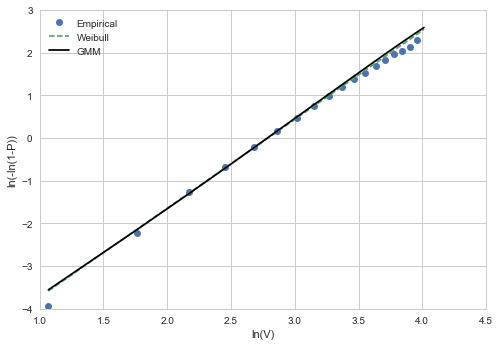

In [60]:
x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(df.speed)

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y_cdf_gmm = array(list(zip(*y_))[0])

plot(log(x), log(-log(1-y_ecdf)),'o', label = 'Empirical')
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')
plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label = 'GMM')
plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Speed Distribution Comparison


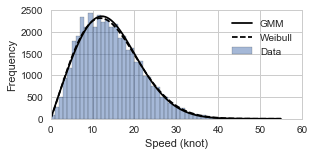

In [61]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y_gmm = array(list(zip(*y_))[0])*len(df.speed)/0.02

# 2. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)

df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')
plot(x, y_gmm,'-', color='black', label='GMM')
plot(x, y_weibul*len(df.speed), '--', color='black', label='Weibull') 
print('Speed Distribution Comparison')
plt_configure(xlabel='Speed'+speed_unit_text,
              ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)

Direction Distribution Comparison


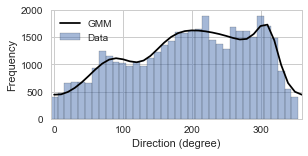

In [62]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction'+dir_unit_text, ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

In [63]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

0.899623476254


## 6.3 Sectoral Comaprison

In [64]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        # 1. Get Weibull and ECDF
        x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(sub_df.speed)
        # 2. Get GMM PDF, CDF
        _, y_gmm, y_cdf_gmm, direction_prob = gmm_integration_in_direction(f, angle_radian-incre_radian/2, angle_radian+incre_radian/2, x)
        
        # 3. Make Plots
        fig = plt.figure(figsize=(13,1.3))
        # 3.1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')                  
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
#         plt_configure(xlabel = "$V$", ylabel='Frequency', legend=True)
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 3.2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
#         plt_configure(xlabel = "$V$", ylabel='$P$', legend=True)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3.3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt.gca().set_xlim(right = log(max_speed+1))
#         plt_configure(xlabel="ln($V$)", ylabel="ln(-ln(1-$P$)",legend={'loc':'best'})
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        
        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'], bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                            for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob, 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle))
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: RuntimeWarning: divide by zero encountered in log


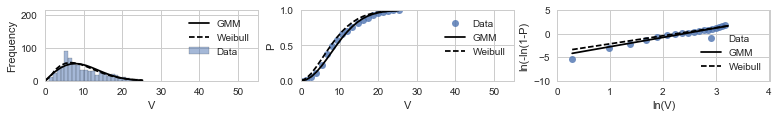

5.0 (-5.0 - 15.0) degree
data size: 676 weight 0.01578075028596774
GMM Weibull
R square 0.730355168189 0.80489262669
max diff: 0.0869695764094 0.0912380433627 speed value: 7.97416170299 y gmm 0.410071843709
 


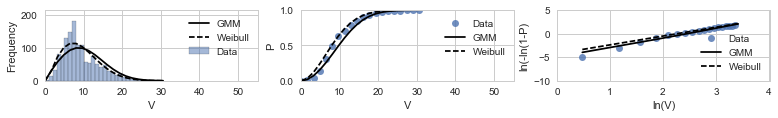

25.0 (15.0 - 35.0) degree
data size: 1348 weight 0.03146812335130845
GMM Weibull
R square 0.755660452413 0.858781010496
max diff: 0.13746683766 0.0964432801176 speed value: 9.65859169864 y gmm 0.49309696056
 


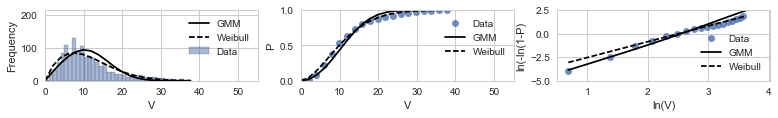

45.0 (35.0 - 55.0) degree
data size: 1339 weight 0.031258024604897634
GMM Weibull
R square 0.790480233004 0.88048842727
max diff: 0.0975214383323 0.0555613267536 speed value: 9.92366856543 y gmm 0.431978188255
 


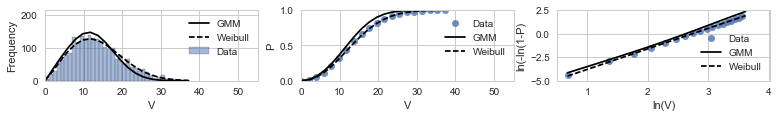

65.0 (55.0 - 75.0) degree
data size: 2180 weight 0.05089058524173028
GMM Weibull
R square 0.928083196538 0.972989492977
max diff: 0.086353942183 0.0202975213032 speed value: 19.5763443179 y gmm 0.897821832091
 


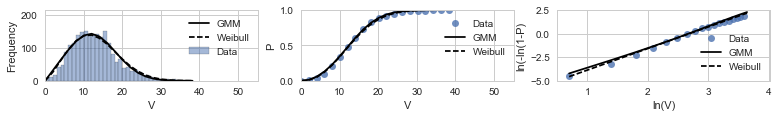

85.0 (75.0 - 95.0) degree
data size: 2183 weight 0.05096061815720055
GMM Weibull
R square 0.961825980214 0.960903593826
max diff: 0.0284435089877 0.0318854979428 speed value: 6.0333808175 y gmm 0.13105459465
 


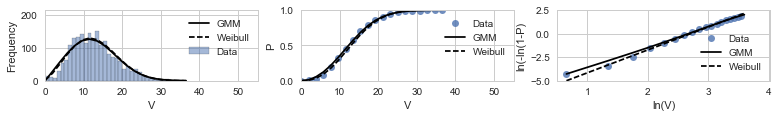

105.0 (95.0 - 115.0) degree
data size: 1983 weight 0.046291757125849146
GMM Weibull
R square 0.935760287149 0.944536117605
max diff: 0.0415543161193 0.0486476660166 speed value: 5.77055870268 y gmm 0.124761577844
 


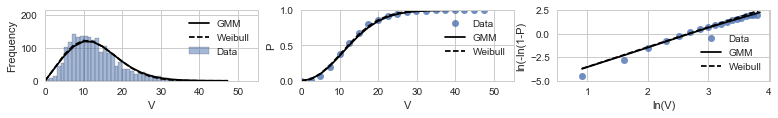

125.0 (115.0 - 135.0) degree
data size: 2007 weight 0.046852020449611315
GMM Weibull
R square 0.940934672435 0.947952761668
max diff: 0.0421127682024 0.0378904106812 speed value: 17.4173530737 y gmm 0.754598741514
 


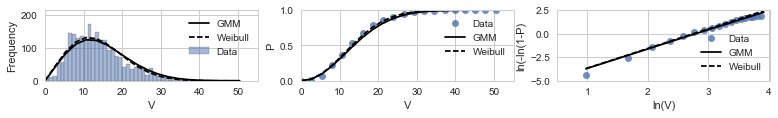

145.0 (135.0 - 155.0) degree
data size: 2353 weight 0.054929150033849246
GMM Weibull
R square 0.921219654876 0.937173699361
max diff: 0.0647058391622 0.0346624363826 speed value: 15.9281825818 y gmm 0.614002193137
 


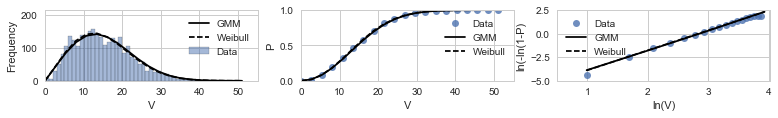

165.0 (155.0 - 175.0) degree
data size: 2785 weight 0.06501388986156827
GMM Weibull
R square 0.963227892205 0.966450309901
max diff: 0.0233106280044 0.0113155997607 speed value: 13.4303381646 y gmm 0.441321328908
 


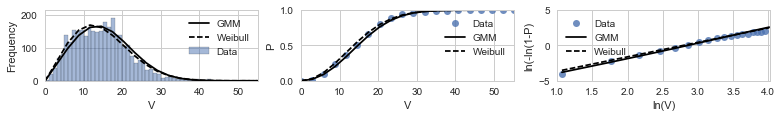

185.0 (175.0 - 195.0) degree
data size: 3167 weight 0.07393141443144945
GMM Weibull
R square 0.958286470299 0.962207312688
max diff: 0.0371064863003 0.0381146686386 speed value: 20.3701318692 y gmm 0.762704059958
 


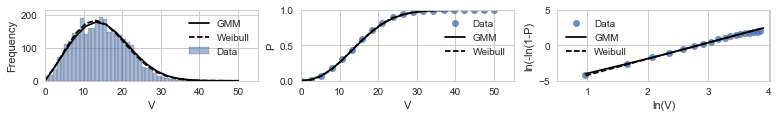

205.0 (195.0 - 215.0) degree
data size: 3267 weight 0.07626584494712516
GMM Weibull
R square 0.978879404985 0.97898254953
max diff: 0.0247236381923 0.0186213779184 speed value: 23.7265488487 y gmm 0.883448997253
 


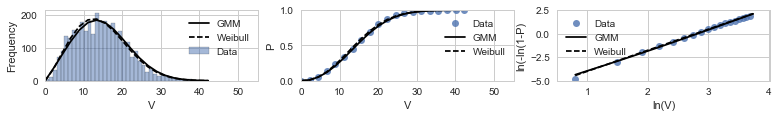

225.0 (215.0 - 235.0) degree
data size: 3333 weight 0.0778065690874711
GMM Weibull
R square 0.964104266154 0.966138104583
max diff: 0.0224199858908 0.018023509969 speed value: 22.2532921017 y gmm 0.850367292837
 


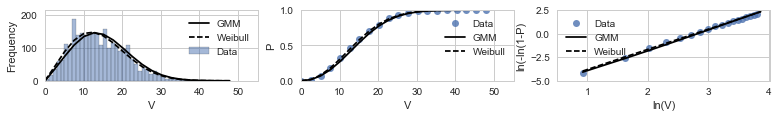

245.0 (235.0 - 255.0) degree
data size: 2665 weight 0.06221257324275743
GMM Weibull
R square 0.915157915987 0.939196649894
max diff: 0.0559102267354 0.0210740583411 speed value: 10.0714022161 y gmm 0.272044745122
 


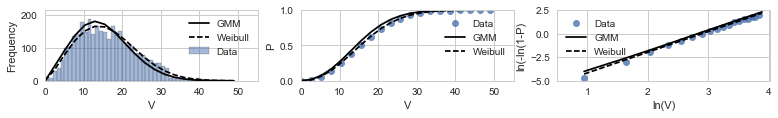

265.0 (255.0 - 275.0) degree
data size: 3307 weight 0.07719961715339543
GMM Weibull
R square 0.939330958462 0.965543539055
max diff: 0.0672148732302 0.0111850781649 speed value: 18.0307520066 y gmm 0.687112061014
 


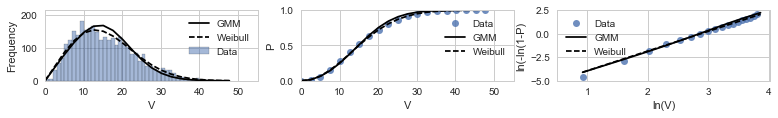

285.0 (275.0 - 295.0) degree
data size: 3132 weight 0.07311436375096295
GMM Weibull
R square 0.914476822192 0.95441040724
max diff: 0.0417508345901 0.030584955331 speed value: 25.1374614148 y gmm 0.906693363326
 


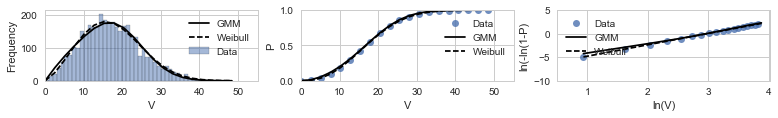

305.0 (295.0 - 315.0) degree
data size: 3596 weight 0.08394612134369821
GMM Weibull
R square 0.970396169485 0.979887482521
max diff: 0.0251218702486 0.0102744857014 speed value: 7.64542434929 y gmm 0.120505629982
 


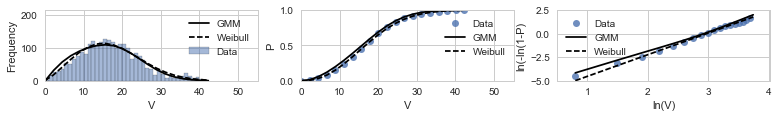

325.0 (315.0 - 335.0) degree
data size: 2358 weight 0.05504587155963303
GMM Weibull
R square 0.922844940628 0.948347829347
max diff: 0.0583657646147 0.0233629976575 speed value: 11.1318044491 y gmm 0.291190192096
 


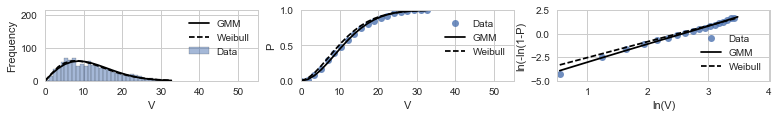

345.0 (335.0 - 355.0) degree
data size: 950 weight 0.02217708989891916
GMM Weibull
R square 0.906514056282 0.929856623497
max diff: 0.0373646342847 0.050898778787 speed value: 6.88790305234 y gmm 0.254214313084
 
Wall time: 1min 9s


In [65]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

0.9305974062703876 0.9516064455371532


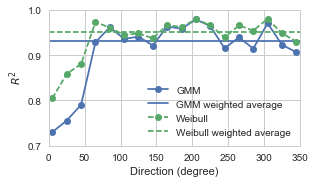

In [66]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$", xlabel='Direction'+dir_unit_text)
ylim = min(plt.gca().get_ylim()[0],0.85)
plt.gca().set_ylim(top=1, bottom=ylim)
print(gmm_mean, weibull_mean)

0.048033883975162936 0.029005480820863416


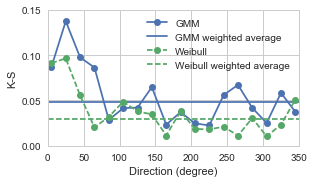

In [67]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S", xlabel='Direction'+dir_unit_text)
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

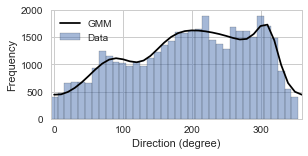

In [68]:
# Compare direction weight with previous figure
display(dir_fig)

## 6.4 Insufficient-fit Sector Investigation

### 6.4.1 Data Variability, by Bootstrap (Resampling)

In [70]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [71]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


25.0 (15.0 - 35.0) Degree Speed Distribution
0.122806953694 10.0 0.518142601203


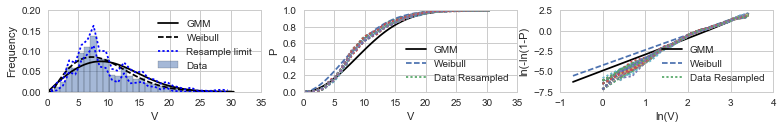

In [72]:
x = arange(0, sub_max_speed, 0.5)
_, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(sub_df.speed, x)
_, y_gmm, y_cdf_gmm, direction_prob = gmm_integration_in_direction(f, angle_radian-incre_radian/2, angle_radian+incre_radian/2, x)

fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_cdf_gmm,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_cdf_gmm)),'-', color = 'black',label='GMM')

# 3. Weilbull 
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_cdf_weibull,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_cdf_weibull)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
#         plt_configure(ax=ax2, xlabel = "$V$", ylabel='$P$', legend={'loc':'best'})
#         plt_configure(ax=ax3, xlabel="ln($V$)", ylabel="ln(-ln(1-$P$)",legend={'loc':'best'})
        plt_configure(ax=ax2, xlabel = "V", ylabel='P', legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (
    
    angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
# plt_configure(ax=ax1, xlabel='$V$',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax1, xlabel='V', ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_cdf_gmm)
print(diff.max(), x[diff.argmax()], y_cdf_gmm[diff.argmax()])

### 6.4.2 Time Variability

In [73]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

ax2.plot(x, y_cdf_gmm,'-', color='black', label = 'GMM')
ax2.plot(x, y_cdf_weibull,'--', label='Weibull')

ax3.plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black',label='GMM')
ax3.plot(log(x), log(-log(1-y_cdf_weibull)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
# plt_configure(ax=ax2, xlabel = "$V$", ylabel='$P$', legend={'loc':'best'})
# plt_configure(ax=ax3, xlabel="ln($V$)", ylabel="ln(-ln(1-$P$)", legend={'loc':'best'})
plt_configure(ax=ax2, xlabel = "V", ylabel='P', legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)", legend={'loc':'best'})

ax1.set_zlim(bottom = 0)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in log


25.0 (15.0 - 35.0) Degree Speed Distribution


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXt4G+WZ9/+dGR1sy/JZtuPYzsGJSSmHkHBoGsjVQikl
lHa3QAi0lFJoCwtXS7sLSymFbMqZdgtvF0JbLqBQSiksfZdsy2EDAdqU97eQNkAKhJCDEye2jpZ1
nvPvD+eZjMYjaSSNbCl6PtfFRSxZo8cazfOd+37u+/swqqqqoFAoFAqFkhd2tgdAoVAoFEotQAWT
QqFQKBQLUMGkUCgUCsUCVDApFAqFQrEAFUwKhUKhUCxABZNCoVAoFAtQwaRQKBQKxQJUMCkUCoVC
sQAVTAqFQqFQLEAFk0KhUCgUC1DBpFAoFArFAlQwKRQKhUKxABVMCoVCoVAsQAWTQqFQKBQLUMGk
UCgUCsUCVDApFAqFMmPs378f3/72t7FmzRp89atfxTe/+U3s3LkTP/vZz/Cxj30Mfr9f+91wOIyP
f/zjePbZZzE6OoqjjjoKv/jFL7KOd+WVV+KSSy6ZkbFTwaRQKBTKjJBOp3HVVVfhsssuw+9+9zs8
9thjuOaaa7B+/XoAwPz58/H8889rv//HP/4Rc+bM0X4eHBzEiy++qP08MTGBkZGRGRu/Y8beiUKh
UChVw3XXXYenn37a1mNecMEFuOeee3I+v3nzZnziE5/ACSecoD123HHH4bHHHsN//Md/YPXq1Xjh
hRfwta99Tfv9T3/609rvtre3o62tDbt27cLQ0BCef/55fO5zn8Nbb71l69+RCxphUigUCmVGGB0d
xeDgoPbzVVddhUsuuQSf+9znMD4+jq6uLjQ2NmL//v0YGRlBb28v3G531jHOOecc/OEPfwAAvPzy
y/jMZz4zY+OnESaFQqHUIffcc0/eaLAS9Pb2Yvv27drPGzZsAACsWbMGsiwDOCyIkiTh3HPPxZYt
W7KO8ZnPfAZf/vKX8aUvfQk+nw8NDQ0zNn4aYVIoFAplRjjjjDPwxhtvYNu2bdpjIyMjGB8fB8Mw
AICzzjoLL7/8Mt566y2ccsop047h8XiwYMEC3HPPPfj85z8/Y2MHqGBSKBQKZYbweDzYsGEDfvWr
X+ErX/kK1q5dixtvvBHf//730dfXBwDwer3o7e3F0UcfDZY1l6hzzz0XW7duxYoVK2Zy+GBUVVVn
9B0pFAqFQqlBaIRJoVAoFIoFqGBSKBQKhWIBWiVLqUsURYEkSRAEARzHgWVZcBwHjuO04gMKhULR
QwWTUlcoigK/34/29nbtZ1VVoaoqkskk4vE4+vr6wLIsGIahQkqhUDSoYFLqAkVRIMsyFEXB2NgY
2traoCgKRFGE0+nUxJAIKOkJIzVxDMNoAkqFlEKpT6hgUo5oSOpVXwyuqiqCwSAikQgYhoEsy3C5
XGBZFpIkIZlMwuVyweFwZImhVSF1OBzazxQK5ciBFv1QjkhkWYYgCBAEQRM3SZK0nRAEQcCCBQuw
YMECLFy4EN3d3XC73VBVFRMTE9i3bx927dqFffv2YXx8HBMTE0gmk5r4EqEEDgupJEngeV5L7SYS
CaRSKaTTafA8D1mWQbu4KPXMpZdeinfeeQfA1DW4fPlyPPTQQ9rzl1xyCd5///1pr3v99dfx1FNP
YXR0FGvWrLH8fitXrtSOu2vXrjJHTyNMyhGGLMta6pWImiRJCIVCmJiYQEtLC1iWxZw5c8BxnFb0
09jYCFVVwfM8+vv7tWPxPA9BEMDzPBKJhCbAbrcbLpcLLpdL+3ehiJTneQAAy7JaBErSujQipdQD
K1euxFtvvYXjjjsOW7duxamnnorXXnsNV1xxBXiex4EDB7BkyZJpr1u1ahWAKS/a2YQKJuWIwEwo
RVFEKBRCNBpFa2srhoaG4HK5EI/Hs1KqueA4Dk1NTWhqasp6nFTXEjFNJBLgeR4Mw2QJKPm3cZ1T
L6SiKGoRK1kX1f+bCimlksyfP/2xiy4C7rijtOf37s3/fp/85CfxwAMP4Otf/zpee+01XHDBBfjx
j3+MeDyOv//97zj55JPx5ptv4qc//Sk4jsPAwADWr1+PjRs3Yvfu3Vi7di0ikQiuvPJKhMNhfOpT
n8LVV1+NG264AatXr8aqVavw+uuv449//CPuvPPO4j4MC1DBpNQ0ZkIpCAJCoRAmJyfR1taGRYsW
wel0FjwWwzCWUqYOhwMOhyNLSIkIEhHNZDKIxWIQBAEMw2giqhdTIo761K4kSdq/iZDqhVOWZVMR
plBqgaOPPhq7d++Gqqp488038b3vfQ8rVqzAX/7yF+zYsQOnnnoqfvjDH+I3v/kNOjs7ce+99+L3
v/89HI7DUpVKpXDPPfegqakJX/7yl3HGGWfM2PipYFJqDlVVs6pe9UIZDAYRi8XQ3t6OxYsXZ11o
BKvCWAwMw2hC6vF4ssZK1jYFQUA6nUY0GtVSwXoRJf8n4qiv3FUUBQDw0UcfYf78+VphkbHYSP86
CqUQhSLCcp83wrIslixZgtdffx0+nw8ulwurVq3Cq6++ig8++ABf/vKX8cMf/hDXXnstACCTyeCT
n/wk5s2bpx1jyZIl8Hq9AIBjjz0We/bsyXqPStYJUMGk1Ay5hJLneQSDQcTjcXR0dOQUSkIuwayU
kDqdzmkRrqqqEEVRK0xKpVKakDocjmnro0RIyTGBbCHVp5hzrZFSKNXAypUr8fOf/xznnHMOAGD5
8uV44IEHAExtEN3b24sHHngAXq8XL7/8MpqamjA2Nqa9fteuXUgmk3C73XjnnXdw4YUX4o033kAw
GAQAvPfeexUbOxVMStVDhDISiSAajWJwcFATykAggEQiYUkojcxmJEbWO10uV9bjREj166OCIEAU
RTgcDu1zaGho0F5vjCr1QioIgvZ+RiE1FilRKDPBJz/5Sdx00024++67AQAulwterxcf+9jHwLIs
fvCDH+Cb3/wmVFWFx+PB3XffnSWYra2t+O53v4tIJILVq1dj0aJFuOCCC3DjjTdi48aNmG+28GoT
dLcSStVC1gVJO0YikUA4HEZvby+CwSASiQQ6OzvR2dkJjuMsH3fnzp0YGBhAQ0ODJigAwPM8xsbG
KnrBlYqqqhAEAfv27UNbW5smqpIkwel0Tkvt6s0Ych0PmC6kDoeDro9SKDmgESal6jAKpX6NMp1O
Y+/evejs7ERfX19RQkmoROq10pDCIYZh0NHRof3dxK2IRKSk0IgIqXF9lAhpMREpdTWiUKaggkmp
GnIJZSqVQjAYRCqVAsuyWLx4cdlrcjO1hllpWJaF2+2G2+3OelxRlKzWF7I+SlyNjK0vZgVDREj1
nwlJ51J7QEo9QgWTMuvkE8pAIIBMJgOfz4fOzk74/f6yxbIeJneWZdHQ0ICGhoasx/UOSDzPI5VK
ged5KIpi2vpits5ptAck70fSuqIooqGhoWBamEKpNahgUmaNXEKZTCYRCAQgCAJ8Ph8GBwfBsizS
6bQtEeBMVslWG8TVqLGxMetxIqTGYiNVVU1bX/KZMezduxd9fX1aCpka1lOOFKhgUmYcM6EEgEQi
gUAgAEmS4PP50NbWljWx2iVo+uPUg0haIZeQFnI1Moopx3FZ55Tu/EI5kqCCSZkx9CblwOHUaDwe
RyAQgCzL6O7uRmtra86Js5LiRsVzOqW4GulbX6xEpLlSu3TnF0q1QQWTUnFkWcbExASam5sBHBam
WCyGYDAIRVHQ3d2NlpaWvBNjJSJMSvEUcjUaGRmBw+FAJpPB5OSkJVcj/TGoYT2lWqGCSakYxJVH
lmWMjIzg4x//OABgcnJSc+Xw+XwFhZJQacGkQloexNWIYRi0tbVpJhL5XI04jjMtNsonpEbDemP7
CxVSSqWggkm

### 6.4.3 Adjacent Sector Variability

In [74]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [75]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


25.0
GMM, Weibull, Histogram


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXuUHGWdPv5U9WWmp+c+0zOTuSWTMBCSMBIBE4zfrCyw
UZSDupCVSFAuihxWDJ5VAQVUUFeCiIcVVmHVNbiGsIriyuV8jQL+gK+CcYMEAknmQmYy0/fpe/Wt
6vfH+FberqnqrqququmZqeccDpmeeftTVV39PvW5PR9GEAQBNmzYsGHDho2yYBf6AGzYsGHDho3F
AJswbdiwYcOGDRWwCdOGDRs2bNhQAZswbdiwYcOGDRWwCdOGDRs2bNhQAZswbdiwYcOGDRWwCdOG
DRs2bNhQAZswbdiwYcOGDRWwCdOGDRs2bNhQAZswbdiwYcOGDRWwCdOGDRs2bNhQAZswbdiwYcOG
DRWwCdOGDRs2bNhQAZswbdiwYcOGDRWwCdOGDRs2bNhQAZswbdiwYcOGZTh+/DhuvPFGbN++HVde
eSU+9alP4ciRI7j//vtx+umnw+/3i38bDoexfv16/OIXv8Dk5CROO+00/OAHPyh5v09/+tPYuXOn
JcduE6YNGzZs2LAEmUwG119/Pa666irs27cPP/nJT/DP//zP+NrXvgYAWLVqFZ566inx75988kms
WLFC/HlwcBDPPPOM+HM0GsXExIRlx++0zJINGzZs2KgZfP7zn8djjz1m6Htedtll2L17t+Lvf//7
32Pz5s3YuHGj+NrIyAh+8pOf4N/+7d9w0UUX4emnn8YnPvEJ8e/PO+888W/b2trQ2tqKY8eOYc2a
NXjqqafwvve9D6+88oqh56EE28O0YcOGDRuWYHJyEoODg+LP119/PXbu3In3ve99mJmZQWdnJzwe
D44fP46JiQn09PSgrq6u5D0+8IEP4De/+Q0AYP/+/bjgggssO37bw7Rhw4aNZYjdu3eX9QbNQE9P
D1577TXx5wcffBAAsH37dhSLRQAnCbFQKODiiy/GCy+8UPIeF1xwAT72sY/hIx/5CHw+H+rr6y07
ftvDtGHDhg0bluD888/HSy+9hP/93/8VX5uYmMDMzAwYhgEAbNu2Dfv378crr7yCTZs2zXsPr9eL
oaEh7N69Gx/84ActO3bAJkwbNmzYsGERvF4vHnzwQfznf/4nrrjiCnz0ox/FrbfeiltuuQW9vb0A
gKamJvT09GDdunVgWXmKuvjii/HnP/8Z5557rpWHD0YQBMFSizZs2LBhw8YihO1h2rBhw4YNGypg
E6YNGzZs2LChAnaVrI1lCZ7nUSgUkMvl4HA4wLIsHA4HHA6HWHxgw4YNGzRswrSxrMDzPPx+P9ra
2sSfBUGAIAhIpVJIJBLo7e0Fy7JgGMYmUhs2bIiwCdPGsgDP8ygWi+B5HtPT02htbQXP88jn83C5
XCIZEgIlPWGkJo5hGJFAbSK1YWN5wiZMG0saJPRKF4MLgoBgMIhIJAKGYVAsFuF2u8GyLAqFAlKp
FNxuN5xOZwkZqiVSp9Mp/mzDho2lA7vox8aSRLFYRC6XQy6XE8mtUCiIkxByuRyGhoYwNDSE1atX
o6urC3V1dRAEAdFoFG+//TaOHTuGt99+GzMzM4hGo0ilUiL5EqIEThJpoVBANpsVQ7vJZBLpdBqZ
TAbZbBbFYhF2F5eN5YyPf/zjePXVVwHMfQfPOussPPzww+Lvd+7ciTfeeGPeuueffx6PPvooJicn
sX37dtX2tmzZIr7vsWPHqjx628O0scRQLBbF0CshtUKhgFAohGg0iubmZrAsixUrVsDhcIhFPx6P
B4IgIJvNor+/X3yvbDaLXC6HbDaLZDIpEnBdXR3cbjfcbrf470oeaTabRaFQQDQaxYoVK8AwjBjW
tT1SG8sBW7ZswSuvvIKRkRH8+c9/xnve8x4899xzuPbaa5HNZjE1NYW1a9fOW7d161YAc1q0Cwmb
MG0sCcgRZT6fRygUwuzsLFpaWrBmzRq43W4kEomSkKoSHA4HGhoa0NDQUPI6qa4lZJpMJpHNZsEw
TAmBkn/TeU5SXESINJ/Pix4ryYvS/7aJ1IaZWLVq/muXXw5885v6fj8+Xt7eu9/9bjzwwAO4+uqr
8dxzz+Gyyy7DPffcg0QigUOHDuFd73oXXn75ZXznO9+Bw+HAwMAAvva1r+HXv/41RkdH8dGPfhSR
SASf/vSnEQ6H8d73vhc33HADbr75Zlx00UXYunUrnn/+eTz55JP413/9V20XQwVswrSxqCFHlLlc
DqFQCLFYDK2trTjllFPgcrkqvhfDMKpCpk6nE06ns4RIiTdJSJTjOMTjceRyOTAMI5Kow+EQC5AI
OdJkWigUxH8TIqWJ0yZSG4sZ69atw+joKARBwMsvv4zPfe5zOPfcc/Hiiy/izTffxHve8x7cdttt
+K//+i90dHTgvvvuw+OPPw6n8yRVpdNp7N69Gw0NDfjYxz6G888/37LjtwnTxqKDIAjgeR6hUAjZ
bBbd3d0iUQaDQcTjcbS1tWF4eLjki0aglhi1gGEYkUi9Xm/JsZLcZi6XQyaTAc/zGB0dhcPhKPFI
yf8JGdKVuzzPi+9H7LEsO6/YiF5nw0YlVPIIq/29FCzLYu3atXj++efh8/ngdruxdetWPPvsszh8
+DA+9rGP4bbbbsOuXbsAABzH4d3vfjdWrlwpvsfatWvR1NQEADjjjDMwNjZWYsPMOgGbMG0sGhCi
JB4l8S6z2SyCwSASiQTa29sViZJAiTDNIlKXyyV6uLlcDlNTU1i1ahXy+bxYmJROpzE7O4tcLgen
0zkvP0oTKUE5Ik2lUvB4PKivrxc9Uhs2agFbtmzB97//fXzgAx8AAJx11ll44IEHAMwNiO7p6cED
DzyApqYm7N+/Hw0NDZienhbXHzt2DKlUCnV1dXj11VfxT//0T3jppZcQDAYBAK+//rppx24Tpo2a
ByFKaYVqoVBAMplELBZTRZRSLIQnRkiZ5DvdbnfJ7wVBQD6fL8mP5nI55PN5OJ3Oed6o2+2e51Xy
PI9wOIy2tjZFj9ThcMwrUrJhwwq8+93vxpe//GXcfffdAAC3242mpiacfvrpYFkWX/rSl/CpT30K
giDA6/Xi7rvvLiHMlpYW3HTTTYhEIrjoootwyimn4LLLLsOtt96KX//611gll3g1CPa0Ehs1C5IX
JO0YZHPnOE70KN1uN4aGhuBwOFS/75EjRzAwMID6+nrkcjnx9Ww2i+npaVO/cPl8HsePH8fq1as1
rRMEQfRG6crdQqEAl8s1L7Tr9/vR3t5eEh6Wvh8wn0idTqctxmDDhgJsD9NGzUGOKBmGQSaTQTAY
RDqdRkdHB7xeL1KplCayBMwJvZoNUjhUV1cn5m8AiGpFhERJoVE+n4ff74fH4ykhU6JqpBTaJQ8Q
NJHaqkY2bMzBJkwbNQMlokyn0wgGg8hkMujs7ER/fz9YlkUsFtNNfFblMM0Gy7IikdI4fvw4Ghsb
wbIscrmcmB8lqkbS1he5giFCpPQ1IeFc8rcktGwTqY3lAJswbSw4eJ5HOp2Gy+WaR5SBQAAcx8Hn
82FgYKCkeEUvwS305m4VKbvd7nkhWVoBKZvNIp1OI5vNgud52fyoXJ6T9JAWi0UcO3YMw8PD8yp2
bY/UxlKETZg2FgzEo+Q4DseOHcPatWvBMAxSqRQCgQByuRx8Ph8GBwdlqzyrIcyF8jCtJBA5W0TV
yOPxlLxOiFRabCQIgmzri9TLtAXrbSwH2IRpw3LIhV6LxSKSySQCgQAKhQJ8Ph9aW1vLbqxGEOZi
DMOaASUiLadqRCICs7OzsqpGgHrBeptIbSwG2IRpwzLQIuXASQ8olUpBEAScOHECXV1daGlpUbVx
Gk12NnnORzl

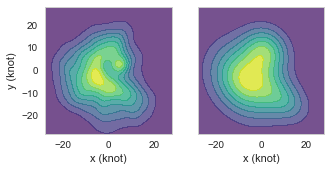

In [76]:
fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_subplot(1,2,1) 
plot_2d_prob_density(X, Y, kde_Z, ax=ax1,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar=False)
ax1.grid(False)
ax2 = fig.add_subplot(1,2,2) 
plot_2d_prob_density(X, Y, pdf_Z, ax=ax2,
                     xlabel='x'+speed_unit_text, ylabel='', colorbar=False)
ax2.grid(False)
ax2.get_yaxis().set_visible(False)

# 7. Result Variability & Cross-Validation

In [77]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}
speed_unit_text=' (knot)'

## 7.1 Variability of the Result

weight  mean_x   mean_y  sig_x   sig_y    corr
1  0.650  -6.837   -4.037  9.551  10.178  -0.174
2  0.204   2.323    9.186  6.537   6.892  -0.082
3  0.146   9.445  -12.736  7.256   6.848  -0.275

GMM Plot Result
0.649959895922 [[-6.83741848 -4.03672423]] [  8.91097831  10.74303516] -145.04110147
0.203649657355 [[ 2.32273334  9.18596985]] [ 6.37974051  7.03704432] -151.367488838
0.146390446723 [[  9.44510927 -12.73602399]] [ 5.98547032  7.98241673] -129.042040779


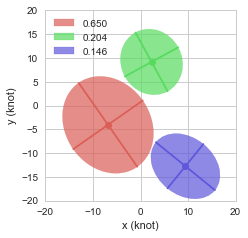

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.016      0.059  2.174157e-09      0.037       0.155

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.016      0.047  2.131414e-09      0.036       0.154

weight  mean_x   mean_y  sig_x   sig_y    corr
1  0.669  -6.416   -4.373  9.727  10.143  -0.187
2  0.201   1.982    9.159  6.656   6.609  -0.133
3  0.130  10.038  -12.660  6.934   6.790  -0.326

GMM Plot Result
0.668850079998 [[-6.41645721 -4.37339474]] [  8.93572178  10.84662722] -141.302080953
0.201181874775 [[ 1.9819114   9.15904092]] [ 6.17628274  7.05941935] -133.477994539
0.129968045227 [[ 10.03772222 -12.65965552]] [ 5.63228054  7.90329042] -133.161154467


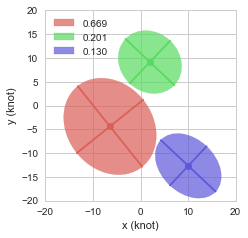

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.016      0.082  2.139150e-09      0.035       0.154

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.017      0.074  2.115484e-09      0.036       0.153

weight  mean_x   mean_y  sig_x   sig_y    corr
1  0.643  -6.493   -4.820  9.929  10.242  -0.233
2  0.233   1.639    8.325  7.110   7.144  -0.083
3  0.123  10.029  -12.719  6.932   6.595  -0.351

GMM Plot Result
0.643414397664 [[-6.49313536 -4.82015621]] [  8.82205043  11.21003419] -138.798317701
0.233403494997 [[ 1.63894595  8.32467617]] [ 6.82361363  7.41813877] -136.639873481
0.123182107339 [[ 10.02861666 -12.71947968]] [ 5.43717388  7.87273849] -130.95595518


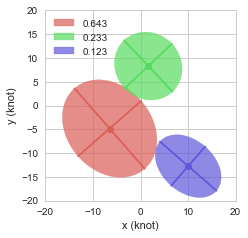

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.979  0.014      0.041  2.288927e-09      0.037       0.160

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.014      0.039  2.139618e-09      0.036       0.154

weight  mean_x  mean_y   sig_x   sig_y    corr
1  0.486  -5.697   3.462   9.967  10.328   0.375
2  0.469   1.364  -9.964  10.863   8.578  -0.287
3  0.045   4.194   6.767   3.597   5.050  -0.476

GMM Plot Result
0.486150597435 [[-5.6967067   3.46191633]] [  8.01553754  11.9063803 ] 137.708528743
0.469003807347 [[ 1.36363914 -9.96365937]] [  7.81174762  11.42683252] -115.149736056
0.0448455952184 [[ 4.19372721  6.766998  ]] [ 2.92171888  5.46876424] -153.006466927


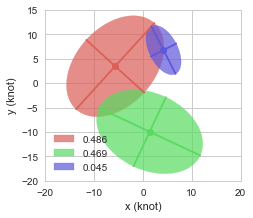

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.981  0.008      0.027  2.017964e-09      0.034       0.150

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.011      0.023  1.952729e-09      0.034       0.147

weight  mean_x   mean_y   sig_x   sig_y    corr
1  0.683  -6.122   -4.470  10.017  10.409  -0.210
2  0.201   1.957    8.894   6.633   6.688  -0.100
3  0.116  10.092  -12.847   7.424   5.994  -0.422

GMM Plot Result
0.682603861143 [[-6.12246644 -4.46979862]] [  9.05881933  11.25315676] -140.170083943
0.201253059706 [[ 1.95725026  8.89412074]] [ 6.31751744  6.98663279] -137.333265451
0.116143079151 [[ 10.09192765 -12.84706449]] [ 4.94267425  8.16178304] -121.474279809


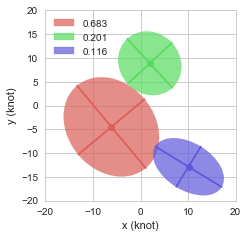

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.016      0.074  2.152616e-09      0.036       0.155

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.015      0.063  2.130928e-09      0.036       0.154

weight  mean_x   mean_y   sig_x   sig_y    corr
1  0.422  -0.697    5.962   8.374   8.012   0.074
2  0.386  -9.019   -8.239  10.024  10.469  -0.502
3  0.192   6.911  -10.709   8.910   6.300  -0.538

GMM Plot Result
0.422220599877 [[-0.69728362  5.96176146]] [ 7.83451199  8.54031345] -60.4696139725
0.385845023865 [[-9.01924004 -8.23923288]] [  7.22163659  12.56704449] -137.471266036
0.191934376258 [[  6.91053446 -10.70932122]] [ 4.83683735  9.78221318] -118.346900952


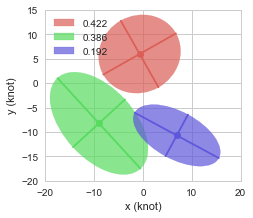

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.981  0.010      0.022  2.058951e-09      0.035       0.151

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.009      0.023  2.174480e-09      0.036       0.155

weight  mean_x   mean_y   sig_x   sig_y    corr
1  0.520  -5.696    3.362   9.972  10.188   0.356
2  0.432   1.572  -10.655  11.015   8.052  -0.261
3  0.048   4.427    5.877   3.398   5.268  -0.502

GMM Plot Result
0.519567696078 [[-5.69625253  3.36225136]] [  8.08699875  11.74051558] 136.726954999
0.432098493873 [[  1.57193943 -10.654566  ]] [  7.51961078  11.3849013 ] -109.681074766
0.0483338100493 [[ 4.42748405  5.8773804 ]] [ 2.74860286  5.63354555] -156.032780083


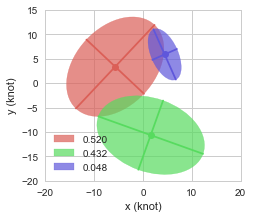

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.984  0.007      0.023  1.756248e-09      0.032       0.140

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.008      0.024  1.955022e-09      0.034       0.147

weight  mean_x  mean_y   sig_x  sig_y    corr
1  0.709  -2.645  -7.455  12.315  9.282  -0.367
2  0.263  -1.456   8.961   7.892  7.359   0.346
3  0.028   5.958   3.722   2.400  3.099  -0.100

GMM Plot Result
0.709083866942 [[-2.64508758 -7.45461868]] [  8.1056344   13.11935083] -116.007902501
0.263383719153 [[-1.45631655  8.96087889]] [ 6.14009556  8.87405784] -50.7092559391
0.0275324139056 [[ 5.95806455  3.72193116]] [ 2.37123491  3.1210995 ] -169.395649985


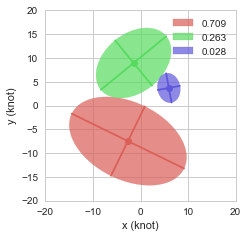

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.010      0.032  1.913367e-09      0.033       0.146

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.012      0.028  1.819318e-09      0.033       0.142

weight  mean_x   mean_y  sig_x   sig_y    corr
1  0.611  -6.939   -5.264  9.613  10.176  -0.280
2  0.265   1.325    8.193  7.385   7.207  -0.049
3  0.125  10.106  -12.416  7.014   6.221  -0.367

GMM Plot Result
0.610616040382 [[-6.93890533 -5.26364243]] [  8.36721779  11.22273865] -140.748378371
0.264786316258 [[ 1.32517592  8.19263035]] [ 7.09455078  7.49381212] -121.777547881
0.12459764336 [[ 10.10607191 -12.415671  ]] [ 5.20523599  7.79731393] -125.927768186


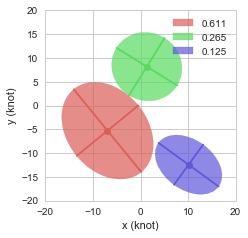

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.016      0.034  2.134804e-09      0.036       0.154

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.980  0.019      0.031  2.175305e-09      0.036       0.155

weight  mean_x   mean_y   sig_x   sig_y    corr
1  0.559  -5.876    2.849  10.060  10.231   0.361
2  0.399   2.579  -10.999  10.530   7.889  -0.249
3  0.042   4.595    5.490   3.241   4.819  -0.526

GMM Plot Result
0.558819371398 [[-5.87578095  2.84922753]] [  8.10737344  11.83792759] 136.339499734
0.399041046407 [[  2.57906353 -10.99924261]] [  7.39214351  10.8844912 ] -110.172781538
0.0421395821946 [[ 4.59451648  5.48954014]] [ 2.54500959  5.21960881] -153.87846095


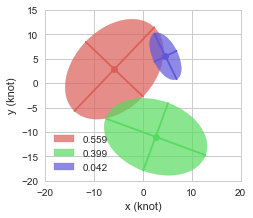

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.007      0.027  1.977460e-09      0.034       0.148

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.008      0.026  1.963573e-09      0.034       0.148


Wall time: 1min 9s


In [78]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax, xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 7.2 Cross-validation, to select the number of Gaussian

In [79]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

Number of train/test dataset

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 32127.75 10709.25
  
Number of gaussian 1
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.077453  0.021781  8.740936e-09    0.072226     0.311567  0.918931
1    0.076200  0.019991  8.149035e-09    0.070588     0.300754  0.924726
2    0.075666  0.020676  8.289801e-09    0.070248     0.303425  0.923379
3    0.074762  0.022464  8.178813e-09    0.069332     0.301443  0.925190

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.075164  0.018972  7.441045e-09    0.065907     0.287454  0.932818
1    0.077712  0.019781  9.111002e-09    0.070688     0.318330  0.916544
2    0.080299  0.022108  8.823280e-09    0.072998     0.313003  0.919276
3    0.090641  0.028025  9.565475e-09    0.077530     0.325719  0.909653

  
Number of gaussian 2
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.035102  0.010712  2.765947e-09    0.040857     0.175305  0.974538
1    0.032432  0.011681  2.683387e-09    0.040463     0.172649  0.975262
2    0.033876  0.010850  2.862537e-09    0.040533     0.178169  0.973727
3    0.030489  0.011648  2.746546e-09    0.040790     0.174707  0.974457

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.036279  0.014499  3.161242e-09    0.043063     0.187231  0.970731
1    0.041411  0.018091  3.441980e-09    0.043737     0.195438  0.968278
2    0.035018  0.010103  2.920048e-09    0.044421     0.180466  0.972736
3    0.040054  0.015401  3.245800e-09    0.042788     0.189661  0.970842

  
Number of gaussian 3
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.055165  0.014876  2.195387e-09    0.035311     0.156153  0.979841
1    0.051232  0.014437  2.135810e-09    0.035820     0.153992  0.980228
2    0.059484  0.015996  2.156859e-09    0.037004     0.154806  0.980124
3    0.068079  0.016223  1.987644e-09    0.034353     0.148542  0.981626

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.073254  0.020735  2.359997e-09    0.039878     0.161860  0.977997
1    0.070417  0.014620  2.574391e-09    0.038886     0.169144  0.976585
2    0.054157  0.016566  2.511934e-09    0.035620     0.166895  0.976837
3    0.083719  0.015103  3.157730e-09    0.043973     0.187376  0.971191

  
Number of gaussian 4
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.015628  0.007127  1.085796e-09    0.025457     0.109803  0.989878
1    0.018727  0.009534  1.098133e-09    0.025345     0.110414  0.989927
2    0.019542  0.007427  1.063913e-09    0.025389     0.108637  0.990243
3    0.017558  0.007959  1.107622e-09    0.025852     0.110995  0.989772

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.023083  0.014170  1.871288e-09    0.033024     0.144184  0.983337
1    0.021167  0.008315  1.621042e-09    0.031923     0.134237  0.984842
2    0.025818  0.011851  1.785314e-09    0.031410     0.141045  0.983300
3    0.030018  0.010180  1.665252e-09    0.031267     0.135672  0.984744

  
Number of gaussian 5
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.015296  0.007667  7.111236e-10    0.021023     0.088945  0.993361
1    0.016694  0.006276  7.271196e-10    0.020805     0.089837  0.993312
2    0.029553  0.005812  1.160304e-09    0.025998     0.113475  0.989380
3    0.350110  0.012224  1.049311e-09    0.024835     0.107921  0.990328

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.018195  0.013272  1.372631e-09    0.027160     0.123142  0.987810
1    0.024831  0.011419  1.272233e-09    0.027475     0.118957  0.988182
2    0.045104  0.008496  1.597665e-09    0.031508     0.133343  0.984942
3    0.934923  0.012855  1.962084e-09    0.033591     0.147730  0.981943

Wall time: 2min 57s


In [80]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

Train gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.076020  0.021228  8.339646e-09    0.070598     0.304297  0.923057
2    0.032975  0.011223  2.764604e-09    0.040661     0.175208  0.974496
3    0.058490  0.015383  2.118925e-09    0.035622     0.153373  0.980455
4    0.017864  0.008012  1.088866e-09    0.025511     0.109962  0.989955
5    0.102913  0.007995  9.119647e-10    0.023165     0.100044  0.991595

Test gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.080954  0.022222  8.735200e-09    0.071781     0.311127  0.919573
2    0.038190  0.014523  3.192267e-09    0.043502     0.188199  0.970647
3    0.070387  0.016756  2.651013e-09    0.039589     0.171319  0.975652
4    0.025021  0.011129  1.735724e-09    0.031906     0.138784  0.984056
5    0.255763  0.011510  1.551153e-09    0.029933     0.130793  0.985719

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


R_square


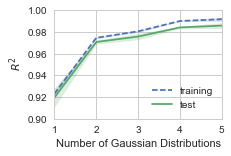

K_S


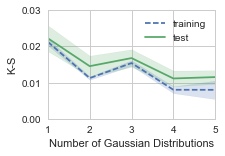

Chi_square


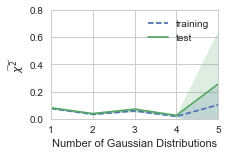

In [81]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'training', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distributions', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.show()

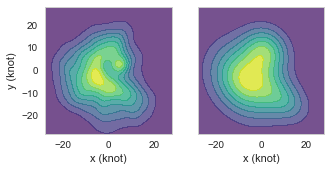

In [82]:
fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_subplot(1,2,1) 
plot_2d_prob_density(X, Y, kde_Z, ax=ax1,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar=False)
ax1.grid(False)
ax2 = fig.add_subplot(1,2,2) 
plot_2d_prob_density(X, Y, pdf_Z, ax=ax2,
                     xlabel='x'+speed_unit_text, ylabel='', colorbar=False)
ax2.grid(False)
ax2.get_yaxis().set_visible(False)

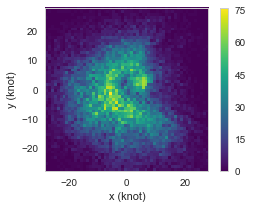

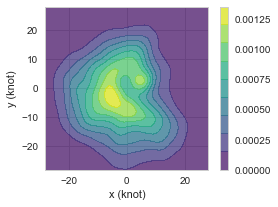

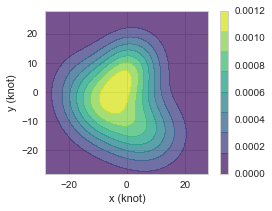

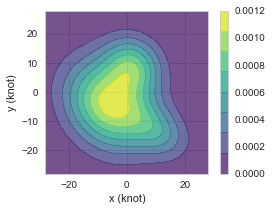

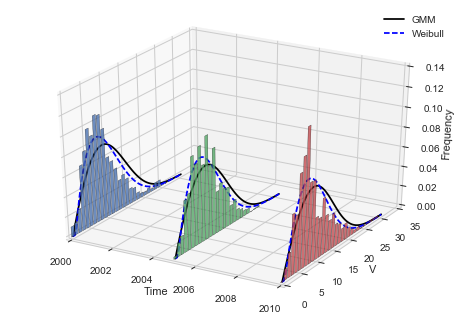

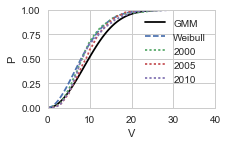

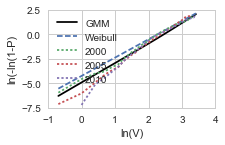

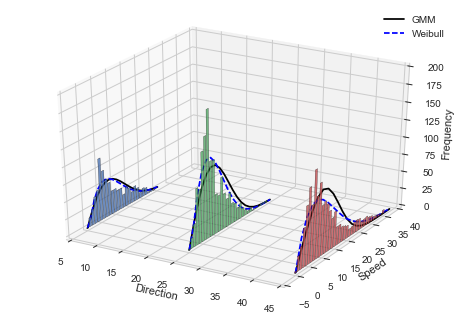

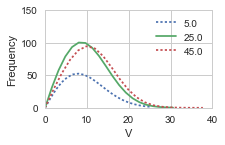

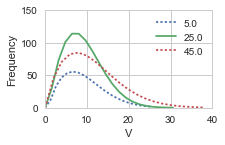

In [83]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [84]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
print(location_name)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)

tiree
